In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# import robustness_metrics as rm
import sklearn
# import tensorflow as tf

import random
from collections import Counter

from utils_notebook import get_logits_targets, modal_probs_decreasing, f_probs_ovr_poe_logits_weighted_generalized, get_scale_probs, \
        anytime_caching, f_probs_pa_softplus, get_logits_targets_image_net, get_metrics_for_paper
from utils_uncertainty import  temper_probs
from utils_conformal import conformalize_anytime_nn, conformalize_anytime_nn_raps

import seaborn as sns
import scipy

from matplotlib.gridspec import GridSpec
# import Line2D
from matplotlib.lines import Line2D

from netcal.metrics import ECE, ACE

import pickle

from matplotlib.ticker import FormatStrFormatter

/home/metod/miniconda3/envs/msdnet2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


IMTA and DViT results below are copied from the following repos:
- IMTA: https://github.com/metodj/IMTA/tree/guarantees
- DViT: https://github.com/metodj/Dynamic-Vision-Transformer/tree/guarantees

In [2]:
import matplotlib 

text_width = 5.50107 # in  --> Confirmed with template explanation
dpi = 300

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1, dpi=dpi, autolayout=True)  # fontsize of the figure 
matplotlib.rc('lines', linewidth=1, markersize=3)
matplotlib.rc('savefig', dpi=1200, bbox='tight')
matplotlib.rc('grid', alpha=0.3)
matplotlib.rc('axes', grid=True)

matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

# Figure 1

In [3]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [4]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [5]:
probs_ca = anytime_caching(probs, N=N, L=L)
preds_ca = {i: torch.argmax(probs_ca, dim=2)[i, :] for i in range(L)}
acc_ca = [(targets == preds_ca[i]).sum() / len(targets) for i in range(L)]

In [6]:
probs_pa = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) ))
preds_pa = {i: torch.argmax(probs_pa, dim=2)[i, :] for i in range(L)}
acc_pa = [(targets == preds_pa[i]).sum() / len(targets) for i in range(L)]

In [5]:
# random.seed(0)

# for _ in range(5):
#     samples = random.sample(range(10000), 10)
#     print(samples)
#     for i in samples:
#         # probs_i = probs[:, i, preds[L - 1][i]].cpu()
#         probs_i = probs[:, i, targets[i]].cpu()
#         plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}')
#     plt.show()

In [6]:
# # # ground-truth probs
# for i in [1528, 6534, 18, 8086, 5458, 3996, 5328, 1031, 3130, 9298]:
#     probs_i = probs[:, i, targets[i]].cpu()
#     plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}')
#     plt.title(f'{i}')
#     plt.show()

In [7]:
# # modal probs
# for i in [6311, 6890, 663, 4242, 8376, 7961, 6634, 4969, 7808, 5866]:
#     probs_i = probs[:, i, preds[L - 1][i]].cpu()
#     # probs_i = probs[:, i, targets[i]].cpu()
#     plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}')
#     plt.title(f'{i}')
#     plt.show()

{0.01: 67.38, 0.1: 49.78, 0.2: 41.72, 0.5: 23.150000000000002}


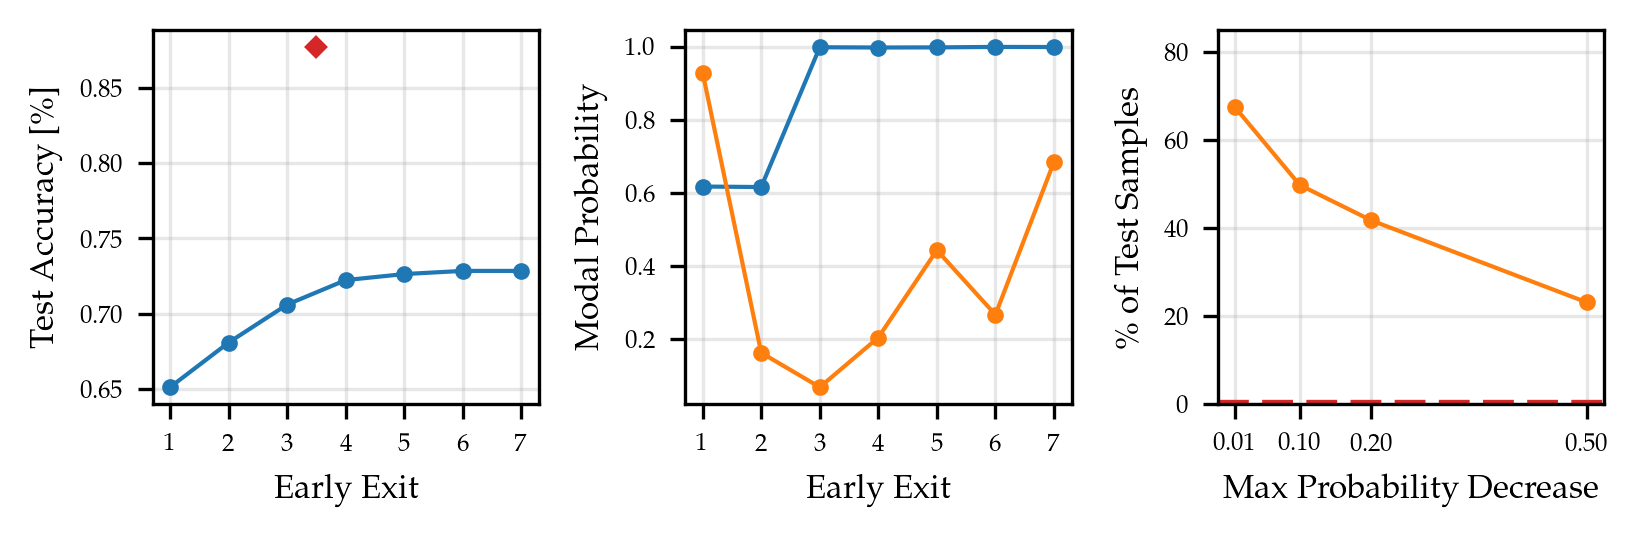

In [8]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})

PLOT_TYPE = 'Modal Probability'
# PLOT_TYPE = 'Ground-Truth Probability'

fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width/3))
early_exits = [i + 1 for i in range(L)]

ax[0].plot(early_exits, acc, label='NN', marker='o')
ax[0].plot([3.5], [0.877], marker='D', color='tab:red')
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Test Accuracy [\%]')
ax[0].set_xticks(early_exits)

ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i in [6311, 8376]:
        probs_i = probs[:, i, preds[L - 1][i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[1].set_xticks(early_exits)

THRESHOLDS = [-0.01, -0.1, -0.2, -0.5]
ax[2].set_xlabel('Max Probability Decrease')
ax[2].set_ylabel('\% of Test Samples')
if PLOT_TYPE == 'Modal Probability':
    probs_decrase = modal_probs_decreasing(preds, probs, L, N=N, diffs_type="all", thresholds=THRESHOLDS)
elif PLOT_TYPE == 'Ground-Truth Probability':
    probs_decrase = modal_probs_decreasing(targets, probs, layer=None, N=N, diffs_type="all", thresholds=THRESHOLDS)
print(probs_decrase)
ax[2].plot(probs_decrase.keys(), probs_decrase.values(), marker='o',  color='tab:orange')
# ax[2].set_xticks(list(probs_decrase.keys()), [int(i * 100) for i in probs_decrase.keys()])
ax[2].set_xticks(list(probs_decrase.keys()))
# ax[2].tick_params(labelsize=11, axis='x')
ax[2].set_ylim([0., 85.])
# ax[2].set_ylabel('\% of Test Samples')
ax[2].axhline(y=0, color="tab:red", linewidth=2, linestyle='--')

plt.tight_layout()
# plt.savefig(f'figures/figure_1_{PLOT_TYPE}.pdf', dpi=1200, bbox_inches='tight')
plt.show()

TODO: add plot for maximum-softmax-probability decreases

/tmp/ipykernel_1971652/2958883410.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


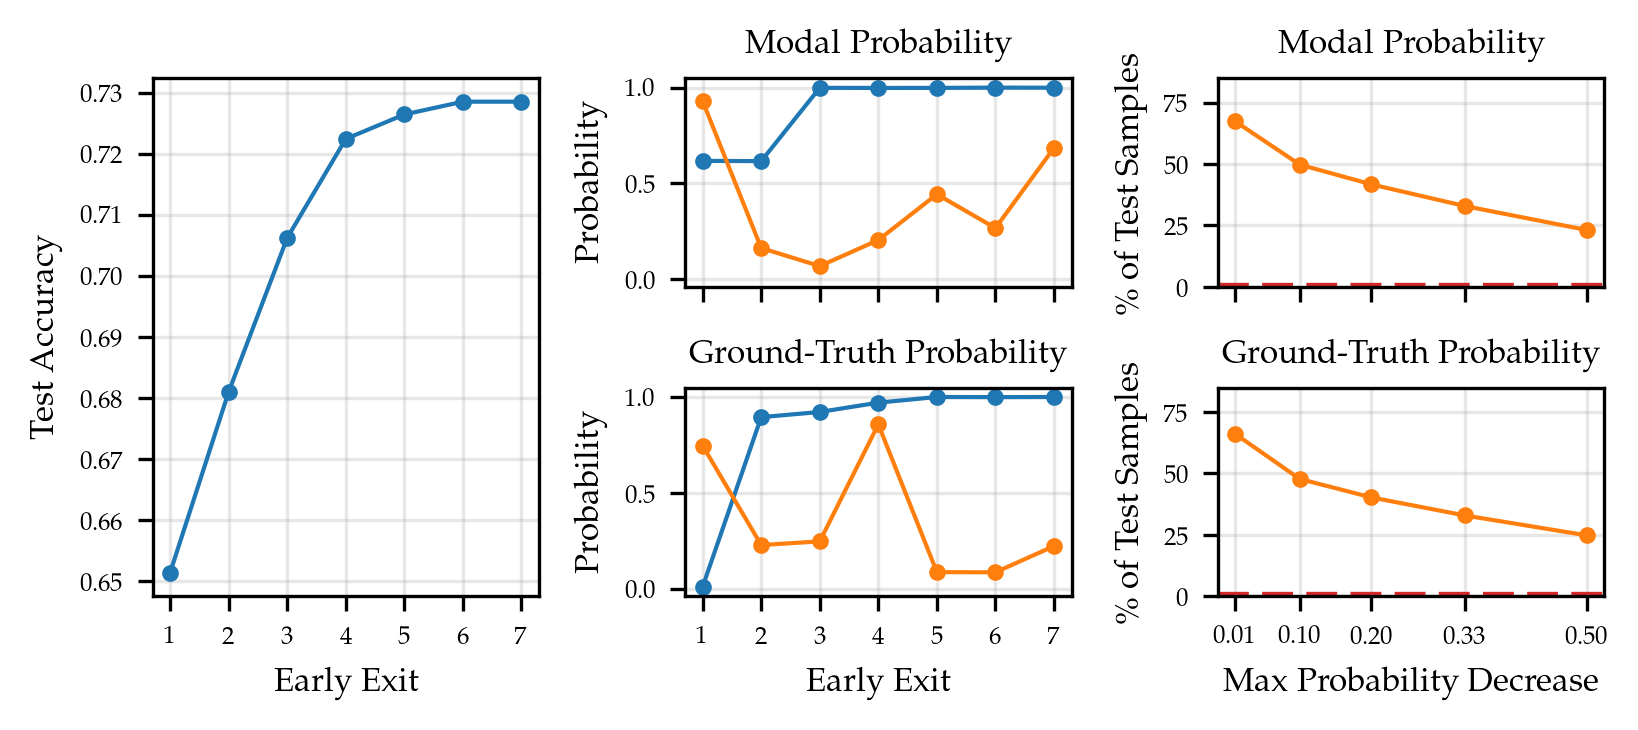

In [9]:
early_exits = [i + 1 for i in range(L)]


def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(constrained_layout=True, figsize=(text_width, text_width*0.45))

gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[0, 2])
ax5 = fig.add_subplot(gs[1, 2])

# fig.suptitle("GridSpec")
# format_axes(fig)

ax1.plot(early_exits, acc, label='NN', marker='o')
ax1.set_xlabel('Early Exit')
ax1.set_ylabel('Test Accuracy')
# ax1.plot([3.5], [0.873], marker='o', markersize=6, color='tab:red')
# ax1.axhline(y=0.873, color="tab:red", linewidth=1, linestyle='--')
ax1.set_xticks(early_exits)

# ax2.set_xlabel('Early Exit')
ax2.set_ylabel('Probability')
ax2.set_title('Modal Probability')
ax2.set_xticks(early_exits)
ax2.set_xticklabels([])
for i in [6311, 8376]:
    probs_i = probs[:, i, preds[L - 1][i]].cpu()
    ax2.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')


ax3.set_xlabel('Early Exit')
ax3.set_ylabel('Probability')
ax3.set_title('Ground-Truth Probability')
ax3.set_xticks(early_exits)
for i in [4969, 6534]:
    probs_i = probs[:, i, targets[i]].cpu()
    ax3.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')

ax3.sharey(ax2)


THRESHOLDS = [-0.01, -0.1, -0.2, -0.33, -0.5]
# ax4.set_xlabel('Max Probability Decrease')
# ax4.set_ylabel('\% of Test Samples')
probs_decrase = modal_probs_decreasing(preds, probs, L, N=N, diffs_type="all", thresholds=THRESHOLDS)

ax4.plot(probs_decrase.keys(), probs_decrase.values(), marker='o',  color='tab:orange')
# ax[2].set_xticks(list(probs_decrase.keys()), [int(i * 100) for i in probs_decrase.keys()])

ax4.set_ylim([0., 85.])
ax4.set_ylabel('\% of Test Samples')
ax4.axhline(y=0, color="tab:red", lw=2, linestyle='--')
ax4.set_title('Modal Probability')
ax4.set_xticks(list(probs_decrase.keys()))
ax4.set_xticklabels([])


ax5.set_xlabel('Max Probability Decrease')
ax5.set_ylabel('\% of Test Samples')
probs_decrase = modal_probs_decreasing(targets, probs, layer=None, N=N, diffs_type="all", thresholds=THRESHOLDS)

ax5.plot(probs_decrase.keys(), probs_decrase.values(), marker='o',  color='tab:orange')
# ax[2].set_xticks(list(probs_decrase.keys()), [int(i * 100) for i in probs_decrase.keys()])
ax5.set_xticks(list(probs_decrase.keys()))
ax5.set_ylim([0., 85.])
# ax[2].set_ylabel('\% of Test Samples')
ax5.axhline(y=0, color="tab:red", linewidth=2, linestyle='--')
ax5.set_title('Ground-Truth Probability')

ax5.sharey(ax4)

# elif PLOT_TYPE == 'Ground-Truth Probability':
#     
# print(probs_decrase)

plt.tight_layout()
plt.savefig(f'figures/figure_1_alt.pdf', dpi=1200, bbox_inches='tight')
plt.show()

/tmp/ipykernel_243339/3548922800.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


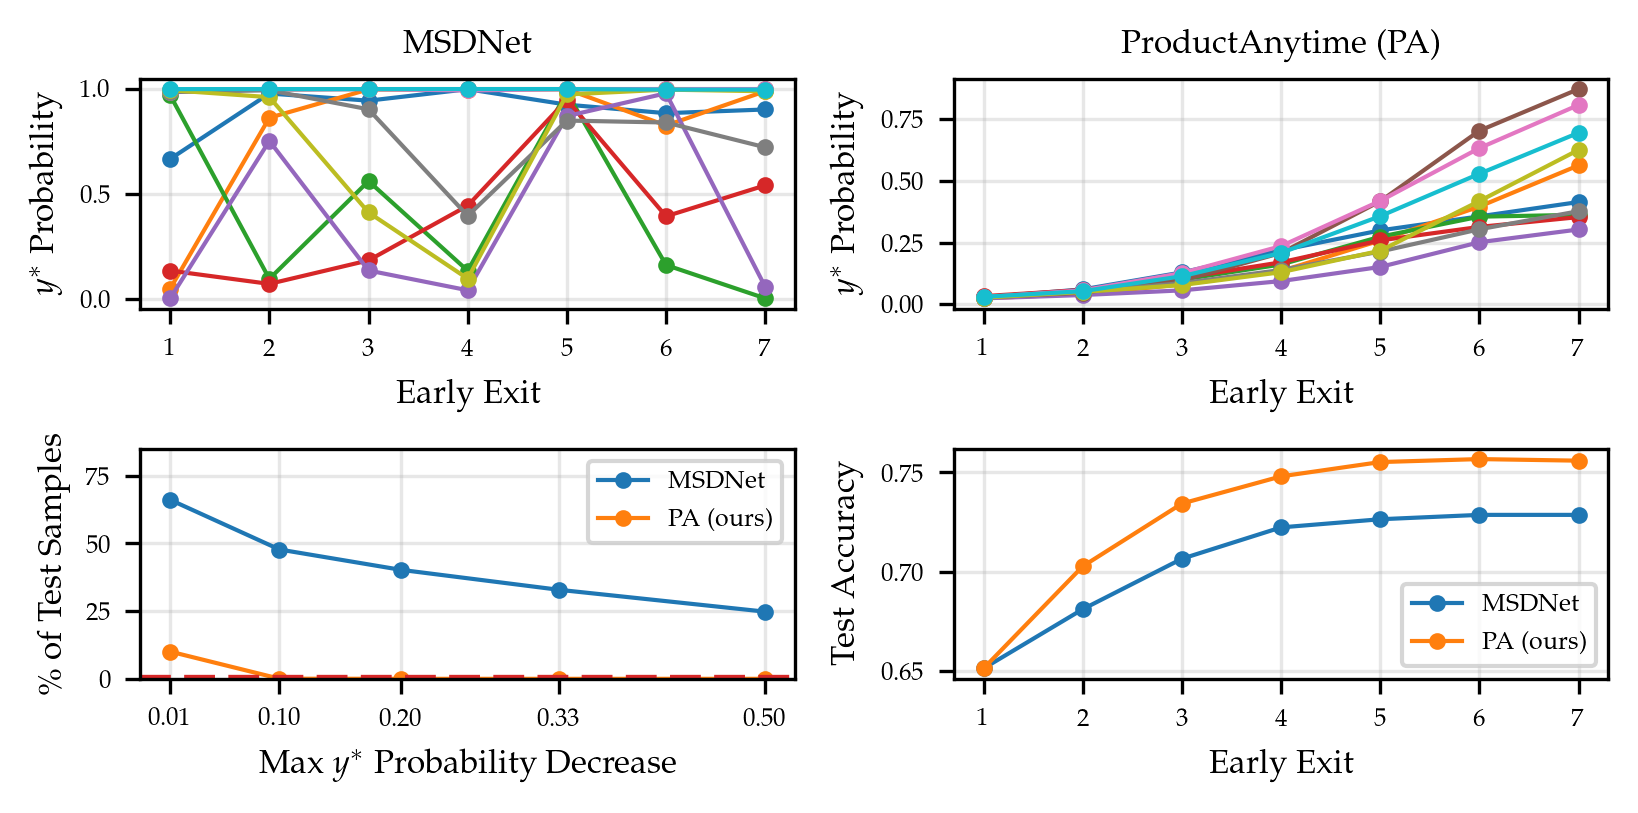

In [13]:
early_exits = [i + 1 for i in range(L)]
THRESHOLDS = [-0.01, -0.1, -0.2, -0.33, -0.5]


def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(constrained_layout=True, figsize=(text_width, text_width*0.5))

gs = GridSpec(2, 2, figure=fig)
# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[1, 0])
# ax3 = fig.add_subplot(gs[0, 1])
# ax4 = fig.add_subplot(gs[1, 1])
ax1 = fig.add_subplot(gs[1, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[0, 1])

# IDS = random.choice(range(len(targets)), 10, replace=False)
np.random.seed(40)
IDS = np.random.randint(0, 10000, 10)
for _probs, _preds, _acc, label in zip([probs, probs_pa], [preds, preds_pa], [acc, acc_pa], ['MSDNet', 'PA (ours)']):
    ax1.plot(early_exits, _acc, label=label, marker='o')


    probs_decrase = modal_probs_decreasing(targets, _probs, layer=None, N=N, diffs_type="all", thresholds=THRESHOLDS)
    ax2.plot(probs_decrase.keys(), probs_decrase.values(), label=label, marker='o')

    # ground-truth probability
    # for i in [4969, 6534]:
    for i in IDS:
        probs_i = _probs[:, i, targets[i]].cpu()
        if label == 'MSDNet':
            ax3.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
        else:
            ax4.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')

ax1.set_xlabel('Early Exit')
ax1.set_ylabel('Test Accuracy')
ax1.set_xticks(early_exits)

ax2.set_xlabel('Max $y^*$ Probability Decrease')
ax2.set_ylabel('\% of Test Samples')
ax2.set_xticks(list(probs_decrase.keys()))
ax2.set_ylim([0., 85.])
ax2.axhline(y=0, color="tab:red", linewidth=2, linestyle='--')

ax4.set_xlabel('Early Exit')
ax4.set_ylabel('$y^*$ Probability')
ax4.set_xticks(early_exits)
ax4.set_title('ProductAnytime (PA)')

ax3.set_xlabel('Early Exit')
ax3.set_ylabel('$y^*$ Probability')
# ax3.set_xticks(early_exits)
ax3.set_title('MSDNet')

ax1.legend(loc='lower right')
ax2.legend(loc='upper right')

ax3.sharex(ax4)
ax4.sharex(ax3)


plt.tight_layout()
plt.savefig(f'figures/figure_1_v3.pdf', dpi=1200, bbox_inches='tight')
plt.show()

/tmp/ipykernel_302490/1344068876.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0])
/tmp/ipykernel_302490/1344068876.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[1])
/tmp/ipykernel_302490/1344068876.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(gs[2])


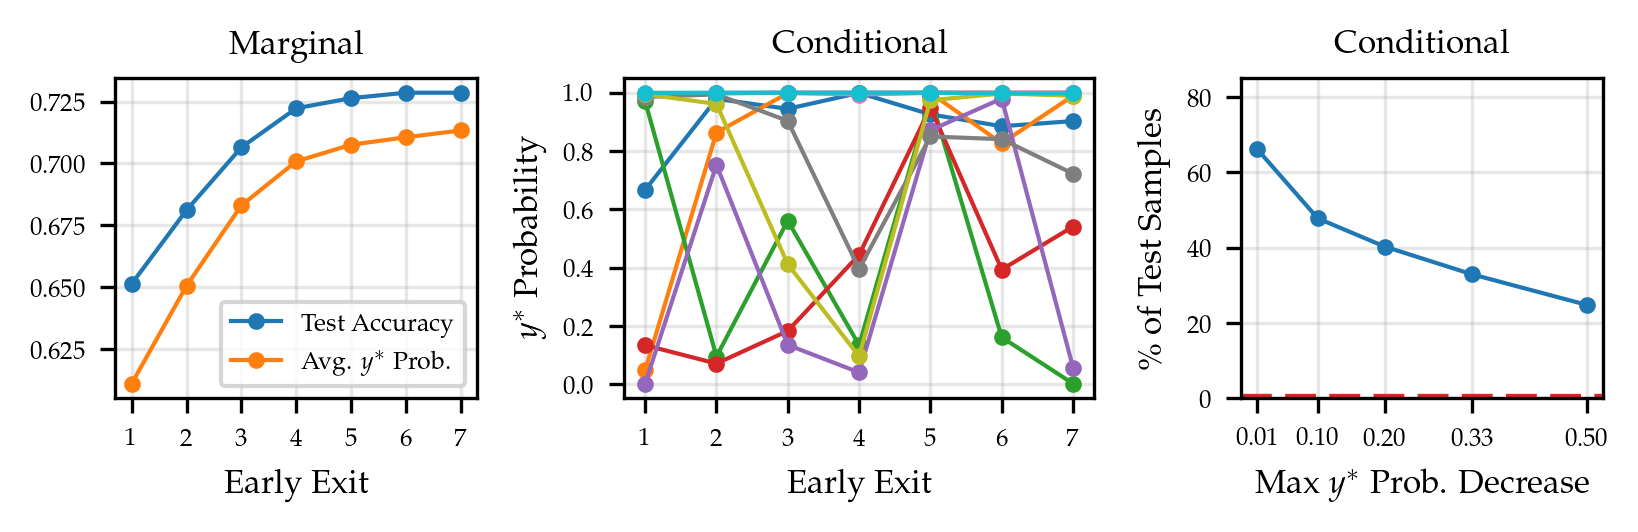

In [13]:
early_exits = [i + 1 for i in range(L)]
THRESHOLDS = [-0.01, -0.1, -0.2, -0.33, -0.5]


def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

gs = GridSpec(1, 3, width_ratios=[1, 1.3, 1])

fig, ax = plt.subplots(1, 3, figsize=(text_width, 0.33*text_width))

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])


np.random.seed(40)
IDS = np.random.randint(0, 10000, 10)
for _probs, _preds, _acc, label in zip([probs], [preds], [acc], ['MSDNet']):

    probs_gt = torch.stack([_probs[:, i, targets[i]] for i in range(N)], dim=1)
    

    ax0.plot(early_exits, _acc, label='Test Accuracy', marker='o', color='tab:blue')
    ax0.plot(early_exits, probs_gt.mean(dim=1), label='Avg. $y^*$ Prob.', marker='o', color='tab:orange')


    probs_decrase = modal_probs_decreasing(targets, _probs, layer=None, N=N, diffs_type="all", thresholds=THRESHOLDS)
    ax2.plot(probs_decrase.keys(), probs_decrase.values(), label=label, marker='o')

    for i in IDS:
        probs_i = _probs[:, i, targets[i]].cpu()
        ax1.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')

ax0.set_xlabel('Early Exit')
ax0.set_xticks(early_exits)

# ax0.set_ylabel('Marginal Properties')
ax0.legend()

ax2.set_xlabel('Max $y^*$ Prob. Decrease')
ax2.set_ylabel('\% of Test Samples')
ax2.set_xticks(list(probs_decrase.keys()))
ax2.set_ylim([0., 85.])
ax2.axhline(y=0, color="tab:red", linewidth=2, linestyle='--')

ax1.set_xlabel('Early Exit')
ax1.set_ylabel('$y^*$ Probability')
ax1.set_xticks(early_exits)
# ax[1].set_title('MSDNet')

ax0.set_title('Marginal')
ax1.set_title('Conditional')
ax2.set_title('Conditional')


plt.tight_layout()
plt.savefig(f'figures/figure_1_v4.pdf', dpi=1200, bbox_inches='tight')
plt.show()

# Figure 2

In [3]:
logits_cifar_100, targets_cifar_100, _ = get_logits_targets('cifar100', 'models', 'softmax', 299)
get_metrics_for_paper(logits=logits_cifar_100, targets=targets_cifar_100, model_name='MSDNet')

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

({'MSDNet': [0.6513, 0.6811, 0.7065, 0.7223, 0.7264, 0.7286, 0.7286],
  'MSDNet-PA': [0.6513, 0.7027, 0.7343, 0.748, 0.7552, 0.7567, 0.7559],
  'MSDNet-CA': [0.6513, 0.6958, 0.7258, 0.742, 0.7472, 0.7492, 0.7515]},
 {'MSDNet': [86.55, 67.37, 56.28, 49.78, 41.67, 38.21, 32.93, 23.15],
  'MSDNet-PA': [0.36, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'MSDNet-CA': [11.73, 10.77, 9.41, 7.96, 6.09, 5.39, 4.62, 2.77]},
 {'MSDNet': [86.46, 66.09, 54.21, 47.75, 40.24, 37.29, 32.88, 24.8],
  'MSDNet-PA': [13.06, 10.05, 1.1, 0.05, 0.0, 0.0, 0.0, 0.0],
  'MSDNet-CA': [25.88, 20.93, 16.72, 13.86, 10.59, 9.88, 8.62, 6.6]})

In [4]:
logits_cifar_10, targets_cifar_10, _ = get_logits_targets('cifar10', 'models_rerun', 'softmax', 299, cuda=True)
get_metrics_for_paper(logits=logits_cifar_10, targets=targets_cifar_10, model_name='MSDNet')

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

({'MSDNet': [0.8926, 0.9059, 0.9183, 0.9206, 0.924, 0.9257, 0.9266],
  'MSDNet-PA': [0.8926, 0.9108, 0.9213, 0.9249, 0.9279, 0.9288, 0.9293],
  'MSDNet-CA': [0.8926, 0.91, 0.9198, 0.9234, 0.9265, 0.927, 0.9281]},
 {'MSDNet': [44.14, 24.41, 17.89, 15.11, 11.7, 10.45, 8.84, 5.6],
  'MSDNet-PA': [3.15, 2.12, 0.47, 0.12, 0.01, 0.0, 0.0, 0.0],
  'MSDNet-CA': [1.85, 1.75, 1.52, 1.32, 1.06, 0.98, 0.78, 0.47]},
 {'MSDNet': [44.12, 24.35, 17.81, 15.05, 12.13, 10.95, 9.58, 6.73],
  'MSDNet-PA': [8.09, 7.32, 5.79, 4.85, 2.66, 1.59, 0.46, 0.02],
  'MSDNet-CA': [6.24, 4.99, 4.03, 3.44, 2.85, 2.61, 2.32, 1.84]})

In [5]:
with open(f'output/ImageNet.p', 'rb') as f:
    data = pickle.load(f)
logits_imagenet, targets_imagenet, _ = data
get_metrics_for_paper(logits=logits_imagenet, targets=targets_imagenet, model_name='MSDNet')

({'MSDNet': [0.5663, 0.6514, 0.6842, 0.6977, 0.7134],
  'MSDNet-PA': [0.5663, 0.6508, 0.6867, 0.7022, 0.7138],
  'MSDNet-CA': [0.5663, 0.6427, 0.676, 0.6912, 0.7044]},
 {'MSDNet': [84.326, 69.972, 51.72, 38.066, 20.518, 14.666, 8.336, 2.024],
  'MSDNet-PA': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'MSDNet-CA': [5.062, 4.452, 2.918, 1.788, 0.638, 0.402, 0.178, 0.022]},
 {'MSDNet': [86.55, 68.232, 47.87, 34.574, 18.696, 13.606, 8.21, 2.25],
  'MSDNet-PA': [1.85, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'MSDNet-CA': [19.678, 14.94, 9.648, 6.464, 3.238, 2.338, 1.344, 0.344]})

In [59]:
# UPDATED RESULTS: April 2023
# CIFAR_10_DICT = {"MSDNet": [0.833, 0.8575, 0.8733, 0.8768, 0.8779, 0.8687, 0.8692], 
#                   "MSDNet-PA": [0.833, 0.8627, 0.8803, 0.8857, 0.8881, 0.884, 0.8838], 
#                   "MSDNet-CA": [0.833, 0.8594, 0.8756, 0.8815, 0.8845, 0.8823, 0.8812],
#                   "IMTA": [0.89, 0.9064, 0.9181, 0.9201, 0.9237, 0.9258, 0.9259], 
#                   "IMTA-PA": [0.89, 0.9033, 0.9131, 0.9186, 0.9215, 0.9227, 0.9252],
#                   "IMTA-CA": [0.89, 0.901, 0.9098, 0.9147, 0.9182, 0.9191, 0.9199],
#                   "DViT": [0.9636, 0.9744, 0.9809],
#                   "DViT-PA": [0.9636, 0.9742, 0.9786],
#                   "DViT-CA": [0.9636, 0.9725, 0.9773],
#                 }

# CIFAR_100_DICT = {"MSDNet": [0.6532, 0.683, 0.7078, 0.7231, 0.7254, 0.7281, 0.7274], 
#                   "MSDNet-PA": [0.6532, 0.7017, 0.7347, 0.7488, 0.7541, 0.7577, 0.7571], 
#                   "MSDNet-CA": [0.6532, 0.6953, 0.7265, 0.7391, 0.7451, 0.748, 0.7516],
#                   "IMTA": [0.6222, 0.6685, 0.6966, 0.7143, 0.7189, 0.7216, 0.7226], 
#                   "IMTA-PA": [0.6222, 0.6665, 0.6958, 0.7148, 0.7255, 0.7316, 0.7331],
#                   "IMTA-CA": [0.6222, 0.6606, 0.6867, 0.707, 0.7168, 0.7218, 0.7234],
#                   "DViT": [0.8374, 0.8579, 0.8716],
#                   "DViT-PA": [0.8374, 0.8642, 0.8756],
#                   "DViT-CA": [0.8374, 0.8607, 0.8738],
#                 }


# IMAGE_NET_DICT = {"MSDNet": [0.5663, 0.6514, 0.6842, 0.6977, 0.7134], 
#                   "MSDNet-PA": [0.5663, 0.6508, 0.6867, 0.7022, 0.7138], 
#                   "MSDNet-CA": [0.5663, 0.6427, 0.676, 0.6912, 0.7044],
#                   "IMTA": [0.5716, 0.6585, 0.6998, 0.7186, 0.7275],
#                   "IMTA-PA": [0.5716, 0.6541, 0.6931, 0.7142, 0.7304],
#                   "IMTA-CA": [0.5716, 0.6467, 0.6868, 0.7078, 0.7219],
#                   "DViT": [0.6906, 0.7566, 0.7999],
#                   "DViT-PA": [0.6906, 0.7529, 0.7904],
#                   "DViT-CA": [0.6906, 0.7496, 0.7889],
#                 }


# UPDATED results: May 2023
# only updated MSDNet results
# CIFAR_10_DICT = {'MSDNet': [0.8926, 0.9059, 0.9183, 0.9206, 0.924, 0.9257, 0.9266],
#   'MSDNet-PA': [0.8926, 0.9108, 0.9213, 0.9249, 0.9279, 0.9288, 0.9293],
#   'MSDNet-CA': [0.8926, 0.91, 0.9198, 0.9234, 0.9265, 0.927, 0.9281],
#                   "IMTA": [0.89, 0.9064, 0.9181, 0.9201, 0.9237, 0.9258, 0.9259], 
#                   "IMTA-PA": [0.89, 0.9033, 0.9131, 0.9186, 0.9215, 0.9227, 0.9252],
#                   "IMTA-CA": [0.89, 0.901, 0.9098, 0.9147, 0.9182, 0.9191, 0.9199],
#                   "DViT": [0.9636, 0.9744, 0.9809],
#                   "DViT-PA": [0.9636, 0.9742, 0.9786],
#                   "DViT-CA": [0.9636, 0.9725, 0.9773],
#                 }

# CIFAR_100_DICT = {'MSDNet': [0.6513, 0.6811, 0.7065, 0.7223, 0.7264, 0.7286, 0.7286],
#   'MSDNet-PA': [0.6513, 0.7027, 0.7343, 0.748, 0.7552, 0.7567, 0.7559],
#   'MSDNet-CA': [0.6513, 0.6958, 0.7258, 0.742, 0.7472, 0.7492, 0.7515],
#                   "IMTA": [0.6222, 0.6685, 0.6966, 0.7143, 0.7189, 0.7216, 0.7226], 
#                   "IMTA-PA": [0.6222, 0.6665, 0.6958, 0.7148, 0.7255, 0.7316, 0.7331],
#                   "IMTA-CA": [0.6222, 0.6606, 0.6867, 0.707, 0.7168, 0.7218, 0.7234],
#                   "DViT": [0.8374, 0.8579, 0.8716],
#                   "DViT-PA": [0.8374, 0.8642, 0.8756],
#                   "DViT-CA": [0.8374, 0.8607, 0.8738],
#                 }


# IMAGE_NET_DICT = {'MSDNet': [0.5663, 0.6514, 0.6842, 0.6977, 0.7134],
#   'MSDNet-PA': [0.5663, 0.6508, 0.6867, 0.7022, 0.7138],
#   'MSDNet-CA': [0.5663, 0.6427, 0.676, 0.6912, 0.7044],
#                   "IMTA": [0.5716, 0.6585, 0.6998, 0.7186, 0.7275],
#                   "IMTA-PA": [0.5716, 0.6541, 0.6931, 0.7142, 0.7304],
#                   "IMTA-CA": [0.5716, 0.6467, 0.6868, 0.7078, 0.7219],
#                   "DViT": [0.6906, 0.7566, 0.7999],
#                   "DViT-PA": [0.6906, 0.7529, 0.7904],
#                   "DViT-CA": [0.6906, 0.7496, 0.7889],
#                 }


# UPDATED results: May 11th 2023, error bars
CIFAR_10_DICT = {'MSDNet': [0.8938, 0.9074, 0.9178, 0.9222, 0.9245, 0.9271, 0.9276],
  'MSDNet-PA': [0.8938, 0.912, 0.9214, 0.9258, 0.9272, 0.9288, 0.9299],
  'MSDNet-CA': [0.8938, 0.9106, 0.9185, 0.9225, 0.9239, 0.926, 0.9274],
                  "IMTA": [0.8925, 0.9089, 0.9176, 0.921, 0.9235, 0.9248, 0.9245], 
                  "IMTA-PA": [0.8925, 0.9066, 0.9152, 0.9194, 0.9221, 0.9238, 0.9251],
                  "IMTA-CA": [0.8925, 0.9052, 0.9112, 0.9153, 0.9184, 0.92, 0.9213],
                  "DViT": [0.9636, 0.9744, 0.9809],
                  "DViT-PA": [0.9636, 0.9742, 0.9786],
                  "DViT-CA": [0.9636, 0.9725, 0.9773],
                }



CIFAR_10_DICT_STDS = {'MSDNet': [0.0041, 0.0008, 0.001, 0.0005, 0.0015, 0.001, 0.0014],
  'MSDNet-PA': [0.0041, 0.0018, 0.0011, 0.0003, 0.0006, 0.001, 0.0004],
  'MSDNet-CA': [0.0041, 0.0017, 0.0004, 0.0004, 0.0012, 0.0013, 0.0008],
                  "IMTA": [0.0018, 0.0018, 0.0004, 0.0014, 0.0023, 0.0024, 0.0026], 
                  "IMTA-PA": [0.0018, 0.0024, 0.0015, 0.0012, 0.0016, 0.0023, 0.0031],
                  "IMTA-CA": [0.0018, 0.003, 0.0013, 0.0007, 0.0012, 0.0018, 0.0019],
                  "DViT": [],
                  "DViT-PA": [],
                  "DViT-CA": [],
                }

CIFAR_100_DICT = {'MSDNet': [0.6315, 0.6614, 0.6905, 0.7038, 0.7141, 0.7208, 0.722],
  'MSDNet-PA': [0.6315, 0.6859, 0.7173, 0.7308, 0.7394, 0.745, 0.7469],
  'MSDNet-CA': [0.6315, 0.6794, 0.7077, 0.7218, 0.7299, 0.7364, 0.739],
                  "IMTA": [0.6209, 0.6668, 0.6902, 0.708, 0.715, 0.7206, 0.7224], 
                  "IMTA-PA": [0.6209, 0.6678, 0.6936, 0.711, 0.7201, 0.7272, 0.7305],
                  "IMTA-CA": [0.6209, 0.6621, 0.6858, 0.7031, 0.7119, 0.7183, 0.7225],
                  "DViT": [0.8374, 0.8579, 0.8716],
                  "DViT-PA": [0.8374, 0.8642, 0.8756],
                  "DViT-CA": [0.8374, 0.8607, 0.8738],
                }



CIFAR_100_DICT_STDS = {'MSDNet': [0.0161, 0.0153, 0.0124, 0.0137, 0.0081, 0.0063, 0.0044],
  'MSDNet-PA': [0.0161, 0.0113, 0.0123, 0.0128, 0.0104, 0.0091, 0.0074],
  'MSDNet-CA': [0.0161, 0.0118, 0.0134, 0.0123, 0.0108, 0.0083, 0.009],
                  "IMTA": [0.001, 0.008, 0.0059, 0.0045, 0.0034, 0.0028, 0.004], 
                  "IMTA-PA": [0.001, 0.0049, 0.0053, 0.0039, 0.0041, 0.0037, 0.0032],
                  "IMTA-CA": [0.001, 0.0042, 0.0041, 0.0035, 0.0041, 0.0037, 0.0032],
                  "DViT": [],
                  "DViT-PA": [],
                  "DViT-CA": [],
                }



IMAGE_NET_DICT = {'MSDNet': [0.5761, 0.6542, 0.6922, 0.7094, 0.7251],
  'MSDNet-PA': [0.5761, 0.6555, 0.693, 0.7122, 0.7258],
  'MSDNet-CA': [0.5761, 0.6468, 0.6834, 0.7019, 0.7164],
                  "IMTA": [0.5716, 0.6585, 0.6998, 0.7186, 0.7275],
                  "IMTA-PA": [0.5716, 0.6541, 0.6931, 0.7142, 0.7304],
                  "IMTA-CA": [0.5716, 0.6467, 0.6868, 0.7078, 0.7219],
                  "DViT": [0.6906, 0.7566, 0.7999],
                  "DViT-PA": [0.6906, 0.7529, 0.7904],
                  "DViT-CA": [0.6906, 0.7496, 0.7889],
                }


IMAGE_NET_DICT_STDS = {'MSDNet': [0.0031, 0.0014, 0.0009, 0.0026, 0.0016],
  'MSDNet-PA': [0.0031, 0.0014, 0.0006, 0.0014, 0.002],
  'MSDNet-CA': [0.0031, 0.001, 0.0008, 0.0018, 0.0023],
                  "IMTA": [], 
                  "IMTA-PA": [],
                  "IMTA-CA": [],
                  "DViT": [],
                  "DViT-PA": [],
                  "DViT-CA": [],
                }


In [60]:
COLOR_DICT = {"MSDNet": "tab:blue", "IMTA": "tab:green", "DViT": "tab:orange"}

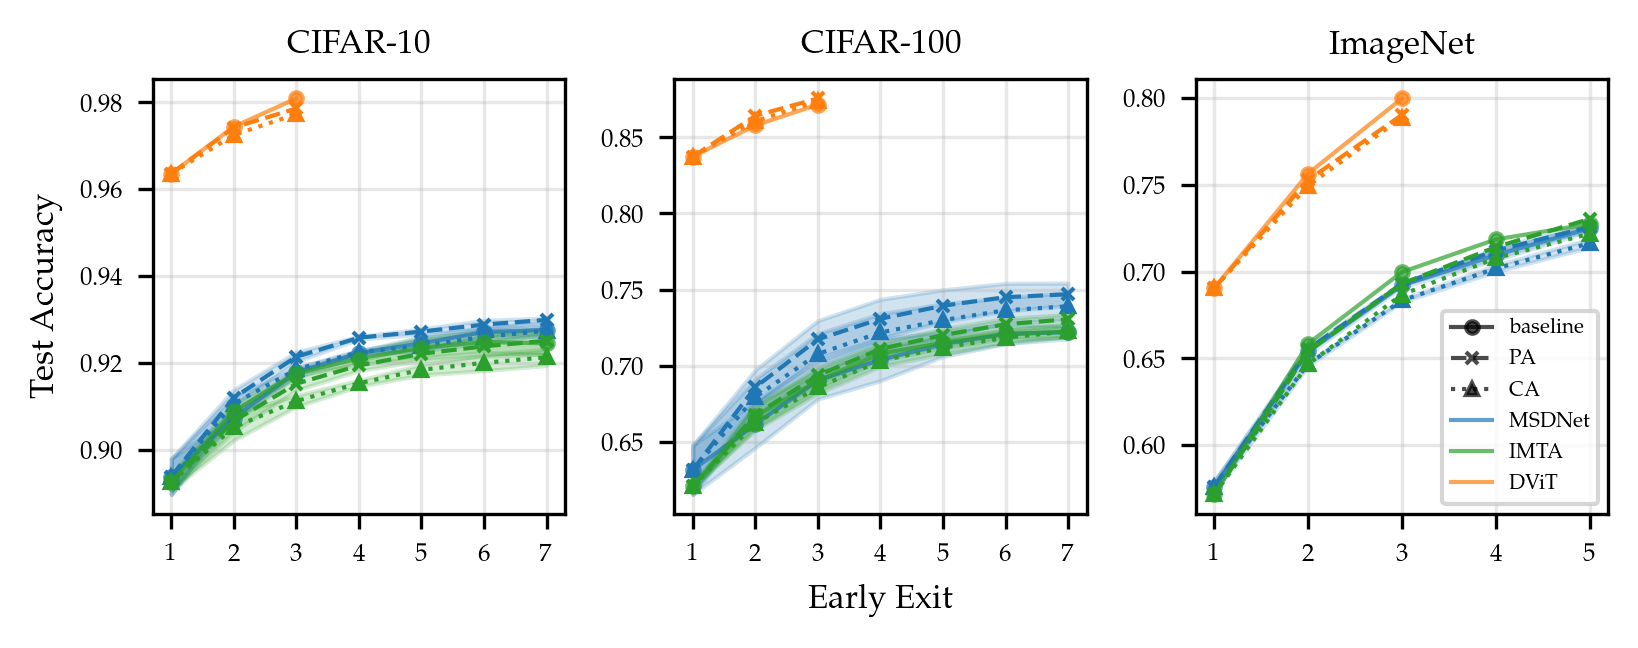

In [24]:
# sns.set_theme()
# FONT_SIZE = 11
# plt.rcParams.update({'font.size': FONT_SIZE})

fig, ax = plt.subplots(1, 3, figsize=(text_width, 0.4*text_width))

ax[0].plot(list(range(1, len(CIFAR_10_DICT["MSDNet"]) + 1)), CIFAR_10_DICT["MSDNet"], label='MSDNet', marker='o', color=COLOR_DICT["MSDNet"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_10_DICT["MSDNet-PA"]) + 1)), CIFAR_10_DICT["MSDNet-PA"], label='MSDNet-PA', marker='x', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["MSDNet-CA"]) + 1)), CIFAR_10_DICT["MSDNet-CA"], label='MSDNet-CA', marker='^', color=COLOR_DICT["MSDNet"], linestyle='dotted')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["IMTA"]) + 1)), CIFAR_10_DICT["IMTA"], label='IMTA', marker='o', color=COLOR_DICT["IMTA"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_10_DICT["IMTA-PA"]) + 1)), CIFAR_10_DICT["IMTA-PA"], label='IMTA-PA', marker='x', color=COLOR_DICT["IMTA"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["IMTA-CA"]) + 1)), CIFAR_10_DICT["IMTA-CA"], label='IMTA-CA', marker='^', color=COLOR_DICT["IMTA"], linestyle='dotted')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["DViT"]) + 1)), CIFAR_10_DICT["DViT"], label='DViT', marker='o', color=COLOR_DICT["DViT"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_10_DICT["DViT-PA"]) + 1)), CIFAR_10_DICT["DViT-PA"], label='DViT-PA', marker='x', color=COLOR_DICT["DViT"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["DViT-CA"]) + 1)), CIFAR_10_DICT["DViT-CA"], label='DViT-CA', marker='^', color=COLOR_DICT["DViT"], linestyle='dotted')

ax[0].fill_between(list(range(1, len(CIFAR_10_DICT["MSDNet"]) + 1)), np.array(CIFAR_10_DICT["MSDNet"]) - np.array(CIFAR_10_DICT_STDS["MSDNet"]), 
                   np.array(CIFAR_10_DICT["MSDNet"]) + np.array(CIFAR_10_DICT_STDS["MSDNet"]), color=COLOR_DICT["MSDNet"], alpha=0.2)
ax[0].fill_between(list(range(1, len(CIFAR_10_DICT["MSDNet-PA"]) + 1)), np.array(CIFAR_10_DICT["MSDNet-PA"]) - np.array(CIFAR_10_DICT_STDS["MSDNet-PA"]), 
                   np.array(CIFAR_10_DICT["MSDNet-PA"]) + np.array(CIFAR_10_DICT_STDS["MSDNet-PA"]), color=COLOR_DICT["MSDNet"], alpha=0.2)
ax[0].fill_between(list(range(1, len(CIFAR_10_DICT["MSDNet-CA"]) + 1)), np.array(CIFAR_10_DICT["MSDNet-CA"]) - np.array(CIFAR_10_DICT_STDS["MSDNet-CA"]), 
                   np.array(CIFAR_10_DICT["MSDNet-CA"]) + np.array(CIFAR_10_DICT_STDS["MSDNet-CA"]), color=COLOR_DICT["MSDNet"], alpha=0.2)
ax[0].fill_between(list(range(1, len(CIFAR_10_DICT["IMTA"]) + 1)), np.array(CIFAR_10_DICT["IMTA"]) - np.array(CIFAR_10_DICT_STDS["IMTA"]), 
                   np.array(CIFAR_10_DICT["IMTA"]) + np.array(CIFAR_10_DICT_STDS["IMTA"]), color=COLOR_DICT["IMTA"], alpha=0.2)
ax[0].fill_between(list(range(1, len(CIFAR_10_DICT["IMTA-PA"]) + 1)), np.array(CIFAR_10_DICT["IMTA-PA"]) - np.array(CIFAR_10_DICT_STDS["IMTA-PA"]), 
                   np.array(CIFAR_10_DICT["IMTA-PA"]) + np.array(CIFAR_10_DICT_STDS["IMTA-PA"]), color=COLOR_DICT["IMTA"], alpha=0.2)
ax[0].fill_between(list(range(1, len(CIFAR_10_DICT["IMTA-CA"]) + 1)), np.array(CIFAR_10_DICT["IMTA-CA"]) - np.array(CIFAR_10_DICT_STDS["IMTA-CA"]), 
                   np.array(CIFAR_10_DICT["IMTA-CA"]) + np.array(CIFAR_10_DICT_STDS["IMTA-CA"]), color=COLOR_DICT["IMTA"], alpha=0.2)
# ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Test Accuracy')
ax[0].set_title('CIFAR-10')
ax[0].set_xticks([x for x in range(1, 8)])
# ax[0].legend()

ax[1].plot(list(range(1, len(CIFAR_100_DICT["MSDNet"]) + 1)), CIFAR_100_DICT["MSDNet"], label='MSDNet', marker='o', color=COLOR_DICT["MSDNet"], alpha=0.7)
ax[1].plot(list(range(1, len(CIFAR_100_DICT["MSDNet-PA"]) + 1)), CIFAR_100_DICT["MSDNet-PA"], label='MSDNet-PA', marker='x', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[1].plot(list(range(1, len(CIFAR_100_DICT["MSDNet-CA"]) + 1)), CIFAR_100_DICT["MSDNet-CA"], label='MSDNet-CA', marker='^', color=COLOR_DICT["MSDNet"], linestyle='dotted')
ax[1].plot(list(range(1, len(CIFAR_100_DICT["IMTA"]) + 1)), CIFAR_100_DICT["IMTA"], label='IMTA', marker='o', color=COLOR_DICT["IMTA"], alpha=0.7)
ax[1].plot(list(range(1, len(CIFAR_100_DICT["IMTA-PA"]) + 1)), CIFAR_100_DICT["IMTA-PA"], label='IMTA-PA', marker='x', color=COLOR_DICT["IMTA"], linestyle='--')
ax[1].plot(list(range(1, len(CIFAR_100_DICT["IMTA-CA"]) + 1)), CIFAR_100_DICT["IMTA-CA"], label='IMTA-CA', marker='^', color=COLOR_DICT["IMTA"], linestyle='dotted')
ax[1].plot(list(range(1, len(CIFAR_100_DICT["DViT"]) + 1)), CIFAR_100_DICT["DViT"], label='DViT', marker='o', color=COLOR_DICT["DViT"], alpha=0.7)
ax[1].plot(list(range(1, len(CIFAR_100_DICT["DViT-PA"]) + 1)), CIFAR_100_DICT["DViT-PA"], label='DViT-PA', marker='x', color=COLOR_DICT["DViT"], linestyle='--')
ax[1].plot(list(range(1, len(CIFAR_100_DICT["DViT-CA"]) + 1)), CIFAR_100_DICT["DViT-CA"], label='DViT-CA', marker='^', color=COLOR_DICT["DViT"], linestyle='dotted')
ax[1].fill_between(list(range(1, len(CIFAR_100_DICT["MSDNet"]) + 1)), np.array(CIFAR_100_DICT["MSDNet"]) - np.array(CIFAR_100_DICT_STDS["MSDNet"]), 
                   np.array(CIFAR_100_DICT["MSDNet"]) + np.array(CIFAR_100_DICT_STDS["MSDNet"]), color=COLOR_DICT["MSDNet"], alpha=0.2)
ax[1].fill_between(list(range(1, len(CIFAR_100_DICT["MSDNet-PA"]) + 1)), np.array(CIFAR_100_DICT["MSDNet-PA"]) - np.array(CIFAR_100_DICT_STDS["MSDNet-PA"]), 
                   np.array(CIFAR_100_DICT["MSDNet-PA"]) + np.array(CIFAR_100_DICT_STDS["MSDNet-PA"]), color=COLOR_DICT["MSDNet"], alpha=0.2)
ax[1].fill_between(list(range(1, len(CIFAR_100_DICT["MSDNet-CA"]) + 1)), np.array(CIFAR_100_DICT["MSDNet-CA"]) - np.array(CIFAR_100_DICT_STDS["MSDNet-CA"]), 
                   np.array(CIFAR_100_DICT["MSDNet-CA"]) + np.array(CIFAR_100_DICT_STDS["MSDNet-CA"]), color=COLOR_DICT["MSDNet"], alpha=0.2)
ax[1].fill_between(list(range(1, len(CIFAR_100_DICT["IMTA"]) + 1)), np.array(CIFAR_100_DICT["IMTA"]) - np.array(CIFAR_100_DICT_STDS["IMTA"]), 
                   np.array(CIFAR_100_DICT["IMTA"]) + np.array(CIFAR_100_DICT_STDS["IMTA"]), color=COLOR_DICT["IMTA"], alpha=0.2)
ax[1].fill_between(list(range(1, len(CIFAR_100_DICT["IMTA-PA"]) + 1)), np.array(CIFAR_100_DICT["IMTA-PA"]) - np.array(CIFAR_100_DICT_STDS["IMTA-PA"]), 
                   np.array(CIFAR_100_DICT["IMTA-PA"]) + np.array(CIFAR_100_DICT_STDS["IMTA-PA"]), color=COLOR_DICT["IMTA"], alpha=0.2)
ax[1].fill_between(list(range(1, len(CIFAR_100_DICT["IMTA-CA"]) + 1)), np.array(CIFAR_100_DICT["IMTA-CA"]) - np.array(CIFAR_100_DICT_STDS["IMTA-CA"]), 
                   np.array(CIFAR_100_DICT["IMTA-CA"]) + np.array(CIFAR_100_DICT_STDS["IMTA-CA"]), color=COLOR_DICT["IMTA"], alpha=0.2)
ax[1].set_xlabel('Early Exit')
# ax[1].set_ylabel('Test Accuracy')
ax[1].set_title('CIFAR-100')
ax[1].set_xticks([x for x in range(1, 8)])
# ax[1].legend()



ax[2].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet"]) + 1)), IMAGE_NET_DICT["MSDNet"], label='MSDNet', marker='o', color=COLOR_DICT["MSDNet"], alpha=0.7)
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet-PA"]) + 1)), IMAGE_NET_DICT["MSDNet-PA"], label='MSDNet-PA', marker='x', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet-CA"]) + 1)), IMAGE_NET_DICT["MSDNet-CA"], label='MSDNet-CA', marker='^', color=COLOR_DICT["MSDNet"], linestyle='dotted')
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["IMTA"]) + 1)), IMAGE_NET_DICT["IMTA"], label='IMTA', marker='o', color=COLOR_DICT["IMTA"], alpha=0.7)
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["IMTA-PA"]) + 1)), IMAGE_NET_DICT["IMTA-PA"], label='IMTA-PA', marker='x', color=COLOR_DICT["IMTA"], linestyle='--')
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["IMTA-CA"]) + 1)), IMAGE_NET_DICT["IMTA-CA"], label='IMTA-CA', marker='^', color=COLOR_DICT["IMTA"], linestyle='dotted')
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["DViT"]) + 1)), IMAGE_NET_DICT["DViT"], label='DViT', marker='o', color=COLOR_DICT["DViT"], alpha=0.7)
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["DViT-PA"]) + 1)), IMAGE_NET_DICT["DViT-PA"], label='DViT-PA', marker='x', color=COLOR_DICT["DViT"], linestyle='--')
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["DViT-CA"]) + 1)), IMAGE_NET_DICT["DViT-CA"], label='DViT-CA', marker='^', color=COLOR_DICT["DViT"], linestyle='dotted')
ax[2].fill_between(list(range(1, len(IMAGE_NET_DICT["MSDNet"]) + 1)), np.array(IMAGE_NET_DICT["MSDNet"]) - np.array(IMAGE_NET_DICT_STDS["MSDNet"]), 
                   np.array(IMAGE_NET_DICT["MSDNet"]) + np.array(IMAGE_NET_DICT_STDS["MSDNet"]), color=COLOR_DICT["MSDNet"], alpha=0.2)
ax[2].fill_between(list(range(1, len(IMAGE_NET_DICT["MSDNet-PA"]) + 1)), np.array(IMAGE_NET_DICT["MSDNet-PA"]) - np.array(IMAGE_NET_DICT_STDS["MSDNet-PA"]), 
                   np.array(IMAGE_NET_DICT["MSDNet-PA"]) + np.array(IMAGE_NET_DICT_STDS["MSDNet-PA"]), color=COLOR_DICT["MSDNet"], alpha=0.2)
ax[2].fill_between(list(range(1, len(IMAGE_NET_DICT["MSDNet-CA"]) + 1)), np.array(IMAGE_NET_DICT["MSDNet-CA"]) - np.array(IMAGE_NET_DICT_STDS["MSDNet-CA"]), 
                   np.array(IMAGE_NET_DICT["MSDNet-CA"]) + np.array(IMAGE_NET_DICT_STDS["MSDNet-CA"]), color=COLOR_DICT["MSDNet"], alpha=0.2)
# ax[2].set_xlabel('Early Exit')
# ax[2].set_ylabel('Test Accuracy')
ax[2].set_title('ImageNet')
# ax[2].legend(fontsize=11)
ax[2].set_xticks([x for x in range(1, 6)])
# ax[2].legend()

# construct a legend with different line styles
lines = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', marker='o', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='x', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='dotted', marker='^', alpha=0.7),
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.7),
]
labels = ['baseline', 'PA', 'CA', 'MSDNet', 'IMTA', 'DViT']
ax[2].legend(lines, labels, loc='lower right', fontsize=5)


plt.tight_layout()
plt.savefig(f'figures/figure_test_accuracy_error_bars.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_405792/1235744829.py:9: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[1].get_shared_x_axes().join(ax[0], ax[1])
/tmp/ipykernel_405792/1235744829.py:38: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[3].get_shared_x_axes().join(ax[2], ax[3])


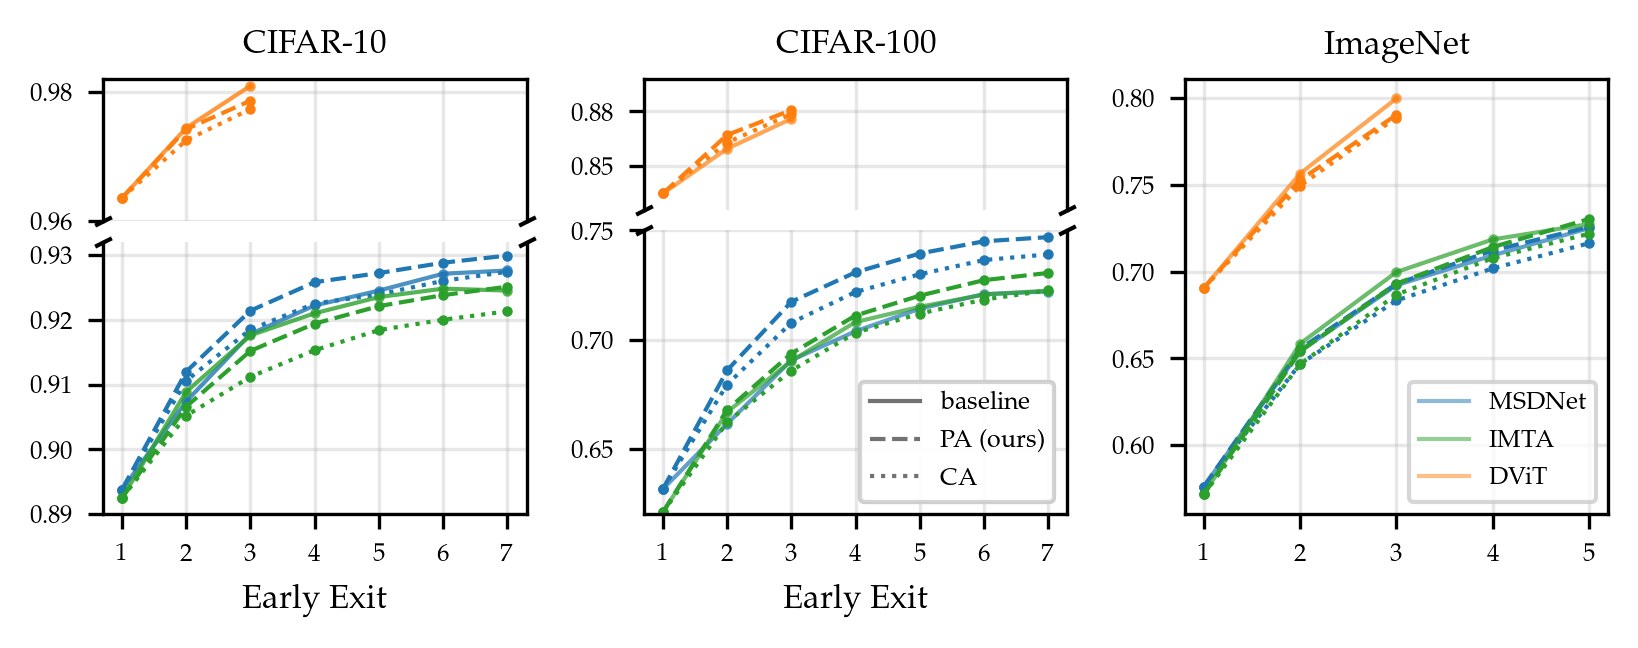

In [84]:
fig = plt.figure(figsize=(text_width, text_width * 0.4))
gs = matplotlib.gridspec.GridSpec(1, 3, figure=fig)
gs0 = gs[0].subgridspec(2, 1, hspace=0.1, height_ratios=[0.982-0.96, 0.932-0.89])
gs1 = gs[1].subgridspec(2, 1, hspace=0.1, height_ratios=[0.89-0.83, 0.75-0.62])

ax = [fig.add_subplot(gs0[0]), fig.add_subplot(gs0[1]), fig.add_subplot(gs1[0]), fig.add_subplot(gs1[1]), fig.add_subplot(gs[:, 2])]


ax[1].get_shared_x_axes().join(ax[0], ax[1])
ax[0].set_title('CIFAR-10')
ax[0].set_ylim([0.96, 0.982])
ax[1].set_xlabel('Early Exit')
ax[1].set_xticks([x for x in range(1, 8)])
ax[1].set_ylim([0.89, 0.932])

# fig.supylabel('Accuracy', fontsize=fs)
ax[0].spines.bottom.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[0].tick_params(axis='x', which='both',length=0, labelbottom=False)
ax[1].xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=4,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

ax[1].plot(list(range(1, len(CIFAR_10_DICT["MSDNet"]) + 1)), CIFAR_10_DICT["MSDNet"], label='MSDNet', marker='o', markersize=1.5, color=COLOR_DICT["MSDNet"], alpha=0.8)
ax[1].plot(list(range(1, len(CIFAR_10_DICT["MSDNet-PA"]) + 1)), CIFAR_10_DICT["MSDNet-PA"], label='MSDNet-PA', marker='o', markersize=1.5, color=COLOR_DICT["MSDNet"], linestyle='--')
ax[1].plot(list(range(1, len(CIFAR_10_DICT["MSDNet-CA"]) + 1)), CIFAR_10_DICT["MSDNet-CA"], label='MSDNet-CA', marker='o', markersize=1.5, color=COLOR_DICT["MSDNet"], linestyle='dotted')
ax[1].plot(list(range(1, len(CIFAR_10_DICT["IMTA"]) + 1)), CIFAR_10_DICT["IMTA"], label='IMTA', marker='o', markersize=1.5, color=COLOR_DICT["IMTA"], alpha=0.8)
ax[1].plot(list(range(1, len(CIFAR_10_DICT["IMTA-PA"]) + 1)), CIFAR_10_DICT["IMTA-PA"], label='IMTA-PA', marker='o', markersize=1.5, color=COLOR_DICT["IMTA"], linestyle='--')
ax[1].plot(list(range(1, len(CIFAR_10_DICT["IMTA-CA"]) + 1)), CIFAR_10_DICT["IMTA-CA"], label='IMTA-CA', marker='o', markersize=1.5, color=COLOR_DICT["IMTA"], linestyle='dotted')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["DViT"]) + 1)), CIFAR_10_DICT["DViT"], label='DViT', marker='o', markersize=1.5, color=COLOR_DICT["DViT"], alpha=0.8)
ax[0].plot(list(range(1, len(CIFAR_10_DICT["DViT-PA"]) + 1)), CIFAR_10_DICT["DViT-PA"], label='DViT-PA', marker='o', markersize=1.5, color=COLOR_DICT["DViT"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["DViT-CA"]) + 1)), CIFAR_10_DICT["DViT-CA"], label='DViT-CA', marker='o', markersize=1.5, color=COLOR_DICT["DViT"], linestyle='dotted')

ax[3].get_shared_x_axes().join(ax[2], ax[3])
ax[2].set_title('CIFAR-100')
ax[2].set_ylim([0.83, 0.89])
ax[3].set_xlabel('Early Exit')
ax[3].set_xticks([x for x in range(1, 8)])
ax[3].set_ylim([0.62, 0.75])
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[3].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


# fig.supylabel('Accuracy', fontsize=fs)
ax[2].spines.bottom.set_visible(False)
ax[3].spines.top.set_visible(False)
ax[2].tick_params(axis='x', which='both',length=0, labelbottom=False)

ax[2].xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=4,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[2].plot([0, 1], [0, 0], transform=ax[2].transAxes, **kwargs)
ax[3].plot([0, 1], [1, 1], transform=ax[3].transAxes, **kwargs)

ax[3].plot(list(range(1, len(CIFAR_100_DICT["MSDNet"]) + 1)), CIFAR_100_DICT["MSDNet"], label='MSDNet', marker='o', markersize=1.5, color=COLOR_DICT["MSDNet"], alpha=0.7)
ax[3].plot(list(range(1, len(CIFAR_100_DICT["MSDNet-PA"]) + 1)), CIFAR_100_DICT["MSDNet-PA"], label='MSDNet-PA', marker='o', markersize=1.5, color=COLOR_DICT["MSDNet"], linestyle='--')
ax[3].plot(list(range(1, len(CIFAR_100_DICT["MSDNet-CA"]) + 1)), CIFAR_100_DICT["MSDNet-CA"], label='MSDNet-CA', marker='o', markersize=1.5, color=COLOR_DICT["MSDNet"], linestyle='dotted')
ax[3].plot(list(range(1, len(CIFAR_100_DICT["IMTA"]) + 1)), CIFAR_100_DICT["IMTA"], label='IMTA', marker='o', markersize=1.5, color=COLOR_DICT["IMTA"], alpha=0.7)
ax[3].plot(list(range(1, len(CIFAR_100_DICT["IMTA-PA"]) + 1)), CIFAR_100_DICT["IMTA-PA"], label='IMTA-PA', marker='o', markersize=1.5, color=COLOR_DICT["IMTA"], linestyle='--')
ax[3].plot(list(range(1, len(CIFAR_100_DICT["IMTA-CA"]) + 1)), CIFAR_100_DICT["IMTA-CA"], label='IMTA-CA', marker='o', markersize=1.5, color=COLOR_DICT["IMTA"], linestyle='dotted')
ax[2].plot(list(range(1, len(CIFAR_100_DICT["DViT"]) + 1)), CIFAR_100_DICT["DViT"], label='DViT', marker='o', markersize=1.5, color=COLOR_DICT["DViT"], alpha=0.7)
ax[2].plot(list(range(1, len(CIFAR_100_DICT["DViT-PA"]) + 1)), CIFAR_100_DICT["DViT-PA"], label='DViT-PA', marker='o', markersize=1.5, color=COLOR_DICT["DViT"], linestyle='--')
ax[2].plot(list(range(1, len(CIFAR_100_DICT["DViT-CA"]) + 1)), CIFAR_100_DICT["DViT-CA"], label='DViT-CA', marker='o', markersize=1.5, color=COLOR_DICT["DViT"], linestyle='dotted')

ax[4].set_title('ImageNet')
ax[4].set_xticks([x for x in range(1, 6)])

ax[4].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet"]) + 1)), IMAGE_NET_DICT["MSDNet"], label='MSDNet', marker='o', markersize=1.5, color=COLOR_DICT["MSDNet"], alpha=0.7)
ax[4].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet-PA"]) + 1)), IMAGE_NET_DICT["MSDNet-PA"], label='MSDNet-PA', marker='o', markersize=1.5, color=COLOR_DICT["MSDNet"], linestyle='--')
ax[4].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet-CA"]) + 1)), IMAGE_NET_DICT["MSDNet-CA"], label='MSDNet-CA', marker='o', markersize=1.5, color=COLOR_DICT["MSDNet"], linestyle='dotted')
ax[4].plot(list(range(1, len(IMAGE_NET_DICT["IMTA"]) + 1)), IMAGE_NET_DICT["IMTA"], label='IMTA', marker='o', markersize=1.5, color=COLOR_DICT["IMTA"], alpha=0.7)
ax[4].plot(list(range(1, len(IMAGE_NET_DICT["IMTA-PA"]) + 1)), IMAGE_NET_DICT["IMTA-PA"], label='IMTA-PA', marker='o', markersize=1.5, color=COLOR_DICT["IMTA"], linestyle='--')
ax[4].plot(list(range(1, len(IMAGE_NET_DICT["IMTA-CA"]) + 1)), IMAGE_NET_DICT["IMTA-CA"], label='IMTA-CA', marker='o', markersize=1.5, color=COLOR_DICT["IMTA"], linestyle='dotted')
ax[4].plot(list(range(1, len(IMAGE_NET_DICT["DViT"]) + 1)), IMAGE_NET_DICT["DViT"], label='DViT', marker='o', markersize=1.5, color=COLOR_DICT["DViT"], alpha=0.7)
ax[4].plot(list(range(1, len(IMAGE_NET_DICT["DViT-PA"]) + 1)), IMAGE_NET_DICT["DViT-PA"], label='DViT-PA', marker='o', markersize=1.5, color=COLOR_DICT["DViT"], linestyle='--')
ax[4].plot(list(range(1, len(IMAGE_NET_DICT["DViT-CA"]) + 1)), IMAGE_NET_DICT["DViT-CA"], label='DViT-CA', marker='o', markersize=1.5, color=COLOR_DICT["DViT"], linestyle='dotted')


lines1 = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='black', lw=1, linestyle='--', alpha=0.5),
    Line2D([0], [0], color='black', lw=1, linestyle='dotted', alpha=0.5),
]
labels1 = [
    "baseline",
    "PA (ours)",
    "CA"
]

lines2 = [
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.5),
]
labels2 = [
    "MSDNet",
    "IMTA",
    "DViT",
]

legend1 = ax[3].legend(lines1, labels1, loc='lower left', bbox_to_anchor=(0.48, 0.))
legend2 = ax[4].legend(lines2, labels2, loc='lower left', bbox_to_anchor=(0.5, 0.))

# Add the legend manually to the current Axes.
ax[3].add_artist(legend1)

plt.tight_layout()
plt.savefig(f'figures/figure_test_accuracy_v2.pdf', bbox_inches='tight')
plt.show()

# Tables 1 & 2

In [86]:
THRESHOLDS = [-x for x in [-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5]]

# UPDATED RESULTS: April 2023
# CIFAR_10_DICT = {"MSDNet": [70.47, 45.98, 34.5, 28.6, 21.15, 18.16, 14.02, 7.43], 
#                   "MSDNet-PA": [5.47, 3.73, 0.98, 0.25, 0.05, 0.03, 0.01, 0.01], 
#                   "MSDNet-CA": [4.13, 4.0, 3.57, 3.12, 2.3, 2.05, 1.59, 0.85],
#                   "IMTA": [47.04, 19.98, 12.82, 9.83, 5.62, 4.55, 3.0, 1.0], 
#                   "IMTA-PA": [1.99, 1.24, 0.27, 0.01, 0.0, 0.0, 0.0, 0.0],
#                   "IMTA-CA": [1.08, 1.01, 0.86, 0.69, 0.44, 0.33, 0.2, 0.08],
#                   "DViT": [37.6, 4.63, 2.65, 1.83, 1.04, 0.79, 0.54, 0.13],
#                   "DViT-PA": [0.43, 0.27, 0.06, 0.03, 0.0, 0.0, 0.0, 0.0],
#                   "DViT-CA": [0.17, 0.16, 0.13, 0.1, 0.07, 0.05, 0.02, 0.0],
#                 }

# CIFAR_100_DICT = {"MSDNet": [86.76, 67.36, 56.36, 50.38, 41.6, 38.05, 32.95, 23.19], 
#                   "MSDNet-PA": [0.36, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
#                   "MSDNet-CA": [12.18, 11.13, 9.56, 8.18, 6.13, 5.36, 4.45, 2.7],
#                   "IMTA": [74.75, 53.61, 41.85, 35.13, 25.96, 22.8, 17.69, 9.39], 
#                   "IMTA-PA": [0.3, 0.15, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0],
#                   "IMTA-CA": [6.97, 6.22, 5.08, 4.28, 3.04, 2.57, 1.96, 0.95],
#                   "DViT": [67.44, 32.98, 20.94, 15.2, 8.62, 6.71, 4.19, 1.29],
#                   "DViT-PA": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                   "DViT-CA": [0.84, 0.78, 0.61, 0.41, 0.24, 0.18, 0.08, 0.02],
#                 }


# IMAGE_NET_DICT = {"MSDNet": [84.326, 69.972, 51.72, 38.066, 20.518, 14.666, 8.336, 2.024], 
#                   "MSDNet-PA": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
#                   "MSDNet-CA": [5.062, 4.452, 2.918, 1.788, 0.638, 0.402, 0.178, 0.022],
#                   "IMTA": [79.162, 61.17, 42.818, 30.452, 15.556, 10.884, 5.71, 1.184],
#                   "IMTA-PA": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                   "IMTA-CA": [4.704, 4.006, 2.592, 1.588, 0.594, 0.31, 0.122, 0.01],
#                   "DViT": [55.22, 49.3, 27.944, 13.108, 3.608, 2.014, 0.756, 0.066],
#                   "DViT-PA": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                   "DViT-CA": [1.51, 1.204, 0.682, 0.342, 0.096, 0.028, 0.006, 0.0],
# }

# UPDATED RESULTS: May 2023
# updated only for MSDNet
CIFAR_10_DICT = {'MSDNet': [44.14, 24.41, 17.89, 15.11, 11.7, 10.45, 8.84, 5.6],
  'MSDNet-PA': [3.15, 2.12, 0.47, 0.12, 0.01, 0.0, 0.0, 0.0],
  'MSDNet-CA': [1.85, 1.75, 1.52, 1.32, 1.06, 0.98, 0.78, 0.47],
                  "IMTA": [47.04, 19.98, 12.82, 9.83, 5.62, 4.55, 3.0, 1.0], 
                  "IMTA-PA": [1.99, 1.24, 0.27, 0.01, 0.0, 0.0, 0.0, 0.0],
                  "IMTA-CA": [1.08, 1.01, 0.86, 0.69, 0.44, 0.33, 0.2, 0.08],
                  "DViT": [37.6, 4.63, 2.65, 1.83, 1.04, 0.79, 0.54, 0.13],
                  "DViT-PA": [0.43, 0.27, 0.06, 0.03, 0.0, 0.0, 0.0, 0.0],
                  "DViT-CA": [0.17, 0.16, 0.13, 0.1, 0.07, 0.05, 0.02, 0.0],
                }

CIFAR_100_DICT = {'MSDNet': [86.55, 67.37, 56.28, 49.78, 41.67, 38.21, 32.93, 23.15],
  'MSDNet-PA': [0.36, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'MSDNet-CA': [11.73, 10.77, 9.41, 7.96, 6.09, 5.39, 4.62, 2.77],
                  "IMTA": [74.75, 53.61, 41.85, 35.13, 25.96, 22.8, 17.69, 9.39], 
                  "IMTA-PA": [0.3, 0.15, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0],
                  "IMTA-CA": [6.97, 6.22, 5.08, 4.28, 3.04, 2.57, 1.96, 0.95],
                  "DViT": [67.44, 32.98, 20.94, 15.2, 8.62, 6.71, 4.19, 1.29],
                  "DViT-PA": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                  "DViT-CA": [0.84, 0.78, 0.61, 0.41, 0.24, 0.18, 0.08, 0.02],
                }


IMAGE_NET_DICT = {'MSDNet': [84.326, 69.972, 51.72, 38.066, 20.518, 14.666, 8.336, 2.024],
  'MSDNet-PA': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'MSDNet-CA': [5.062, 4.452, 2.918, 1.788, 0.638, 0.402, 0.178, 0.022],
                  "IMTA": [79.162, 61.17, 42.818, 30.452, 15.556, 10.884, 5.71, 1.184],
                  "IMTA-PA": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                  "IMTA-CA": [4.704, 4.006, 2.592, 1.588, 0.594, 0.31, 0.122, 0.01],
                  "DViT": [55.22, 49.3, 27.944, 13.108, 3.608, 2.014, 0.756, 0.066],
                  "DViT-PA": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                  "DViT-CA": [1.51, 1.204, 0.682, 0.342, 0.096, 0.028, 0.006, 0.0],
}


SELECTED_THRESHOLDS = [0.01, 0.1, 0.25]

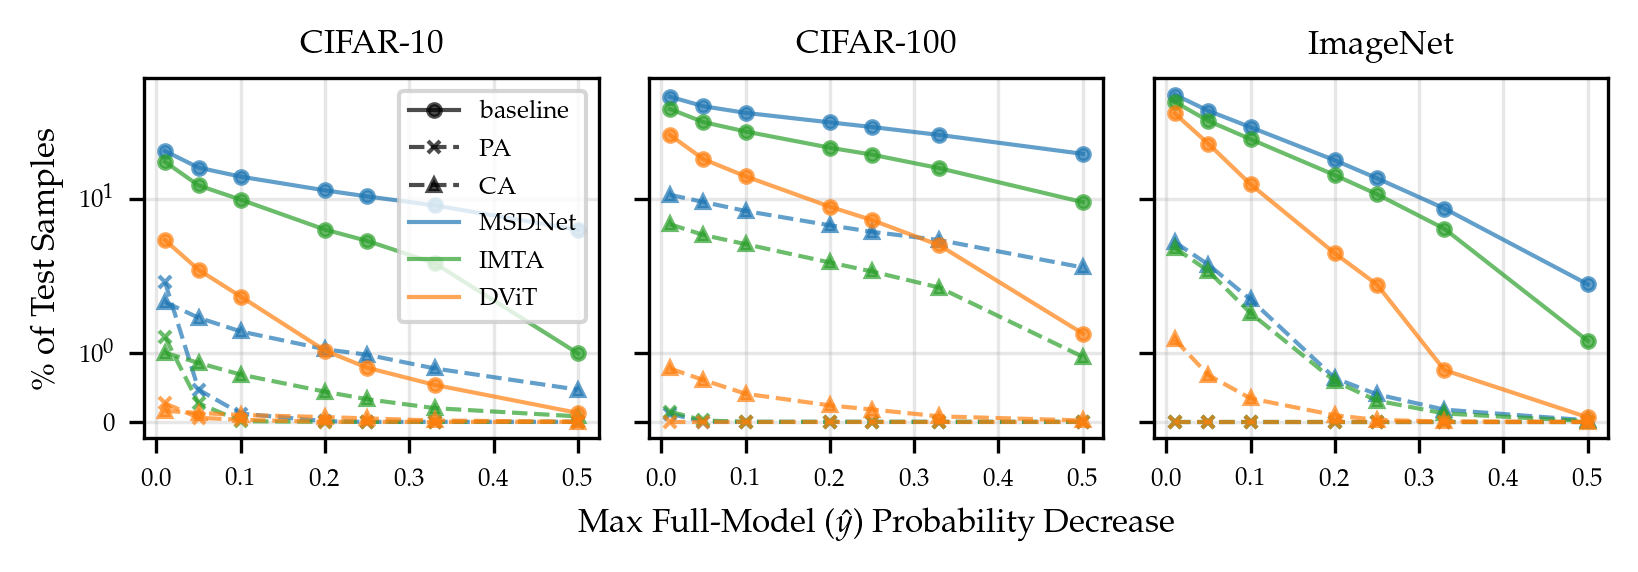

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width * 4.25/12), sharex=True, sharey=True)

colors = {'MSDNet': 'tab:blue', 'MSDNet-PA': 'tab:blue', 'MSDNet-CA': 'tab:blue', 
          'IMTA': 'tab:green', 'IMTA-PA': 'tab:green', 'IMTA-CA': 'tab:green', 
          'DViT': 'tab:orange', 'DViT-PA': 'tab:orange', 'DViT-CA': 'tab:orange'}
line_styles = {'MSDNet': '-', 'MSDNet-PA': '--', 'MSDNet-CA': '--', 
               'IMTA': '-', 'IMTA-PA': '--', 'IMTA-CA': '--',
               'DViT': '-', 'DViT-PA': '--', 'DViT-CA': '--'}
marker_styles = {'MSDNet': 'o', 'MSDNet-PA': 'x', 'MSDNet-CA': '^', 
                 'IMTA': 'o', 'IMTA-PA': 'x', 'IMTA-CA': '^', 
                 'DViT': 'o', 'DViT-PA': 'x', 'DViT-CA': '^'}

for name, percentages in CIFAR_10_DICT.items():
    ax[0].plot(THRESHOLDS[1:], percentages[1:], marker=marker_styles[name], label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

# ax[0].set_xlabel('Max Probability Decrease')
ax[0].set_ylabel('\% of Test Samples')
# ax[0].legend()
# set log scale
ax[0].set_yscale('symlog')
ax[0].set_title('CIFAR-10')

for name, percentages in CIFAR_100_DICT.items():
    ax[1].plot(THRESHOLDS[1:], percentages[1:], marker=marker_styles[name], label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

ax[1].set_xlabel('Max Full-Model ($\hat{y}$) Probability Decrease')
# ax[1].set_ylabel('\% of Test Samples')
# ax[1].legend()
# set log scale
ax[1].set_yscale('symlog')
ax[1].set_title('CIFAR-100')

for name, percentages in IMAGE_NET_DICT.items():
    ax[2].plot(THRESHOLDS[1:], percentages[1:], marker=marker_styles[name], label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

# ax[2].set_xlabel('Max Probability Decrease')
# ax[2].set_ylabel('\% of Test Samples')
# ax[2].legend()
# set log scale
ax[2].set_yscale('symlog')
ax[2].set_title('ImageNet')
# ax[2].set_xticks(THRESHOLDS)

# construct a legend with different line styles
lines = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', marker='o', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='x', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='^', alpha=0.7),
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.7),
]
labels = ['baseline', 'PA', 'CA', 'MSDNet', 'IMTA', 'DViT']
ax[0].legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.savefig(f'figures/figure_full_model_pred_cond_mono.pdf', dpi=1200, bbox_inches='tight')
plt.show()

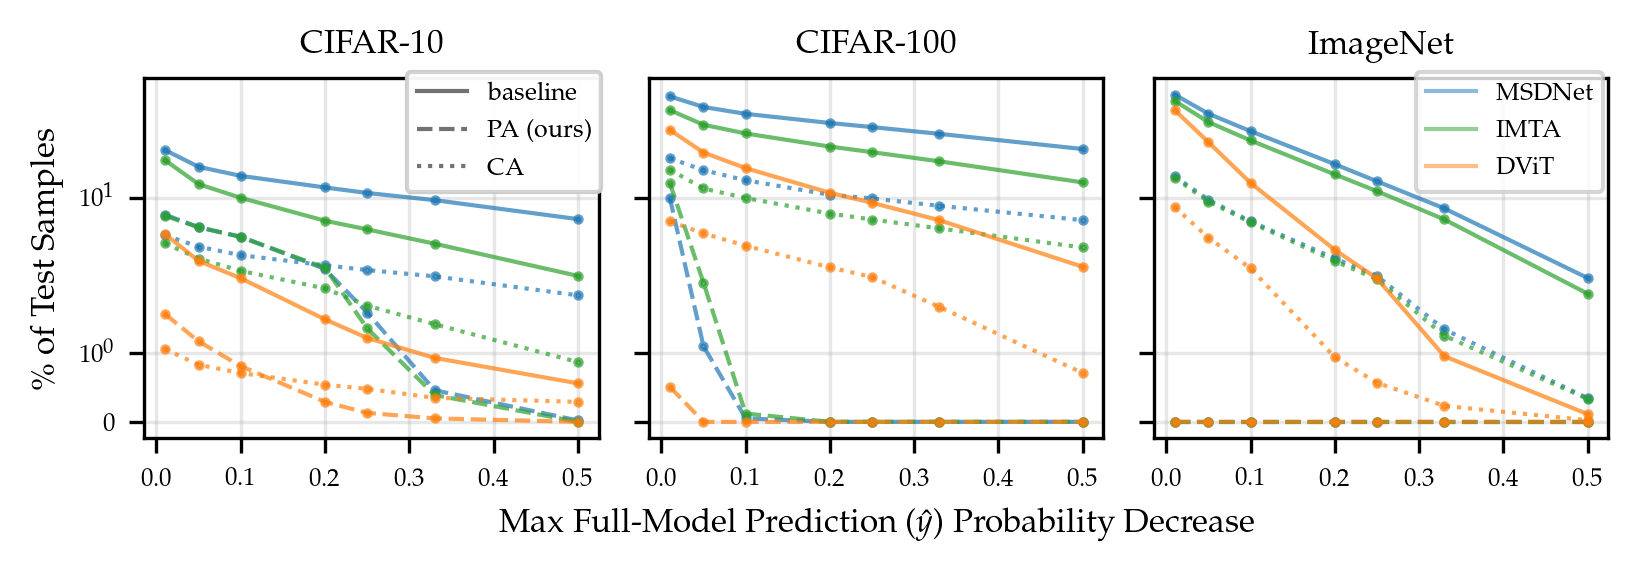

In [97]:
fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width * 4.25/12), sharex=True, sharey=True)

colors = {'MSDNet': 'tab:blue', 'MSDNet-PA': 'tab:blue', 'MSDNet-CA': 'tab:blue', 
          'IMTA': 'tab:green', 'IMTA-PA': 'tab:green', 'IMTA-CA': 'tab:green', 
          'DViT': 'tab:orange', 'DViT-PA': 'tab:orange', 'DViT-CA': 'tab:orange'}
line_styles = {'MSDNet': '-', 'MSDNet-PA': '--', 'MSDNet-CA': 'dotted', 
               'IMTA': '-', 'IMTA-PA': '--', 'IMTA-CA': 'dotted',
               'DViT': '-', 'DViT-PA': '--', 'DViT-CA': 'dotted'}
marker_styles = {'MSDNet': 'o', 'MSDNet-PA': 'x', 'MSDNet-CA': '^', 
                 'IMTA': 'o', 'IMTA-PA': 'x', 'IMTA-CA': '^', 
                 'DViT': 'o', 'DViT-PA': 'x', 'DViT-CA': '^'}

for name, percentages in CIFAR_10_DICT.items():
    ax[0].plot(THRESHOLDS[1:], percentages[1:], marker='o', markersize=1.5, label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

# ax[0].set_xlabel('Max Probability Decrease')
ax[0].set_ylabel('\% of Test Samples')
# ax[0].legend()
# set log scale
ax[0].set_yscale('symlog')
ax[0].set_title('CIFAR-10')

for name, percentages in CIFAR_100_DICT.items():
    ax[1].plot(THRESHOLDS[1:], percentages[1:], marker='o', markersize=1.5, label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

ax[1].set_xlabel('Max Full-Model Prediction ($\hat{y}$) Probability Decrease')
# ax[1].set_ylabel('\% of Test Samples')
# ax[1].legend()
# set log scale
ax[1].set_yscale('symlog')
ax[1].set_title('CIFAR-100')

for name, percentages in IMAGE_NET_DICT.items():
    ax[2].plot(THRESHOLDS[1:], percentages[1:], marker='o', markersize=1.5, label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

# ax[2].set_xlabel('Max Probability Decrease')
# ax[2].set_ylabel('\% of Test Samples')
# ax[2].legend()
# set log scale
ax[2].set_yscale('symlog')
ax[2].set_title('ImageNet')
# ax[2].set_xticks(THRESHOLDS)


lines1 = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='black', lw=1, linestyle='--', alpha=0.5),
    Line2D([0], [0], color='black', lw=1, linestyle='dotted', alpha=0.5),
]
labels1 = [
    "baseline",
    "PA (ours)",
    "CA"
]

lines2 = [
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.5),
]
labels2 = [
    "MSDNet",
    "IMTA",
    "DViT",
]

legend1 = ax[0].legend(lines1, labels1, loc='lower left', bbox_to_anchor=(0.55, 0.65))
legend2 = ax[2].legend(lines2, labels2, loc='lower left', bbox_to_anchor=(0.55, 0.65))

# Add the legend manually to the current Axes.
ax[0].add_artist(legend1)

plt.tight_layout()
plt.savefig(f'figures/figure_full_model_pred_cond_mono_v2.pdf', dpi=1200, bbox_inches='tight')
plt.show()

# Figure 3

In [36]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [37]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [38]:
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

In [40]:
probs_stateful = anytime_caching(probs, N=N, L=L)
preds_stateful = {i: torch.argmax(probs_stateful, dim=2)[i, :] for i in range(L)}
acc_stateful = [(targets == preds_stateful[i]).sum() / len(targets) for i in range(L)]

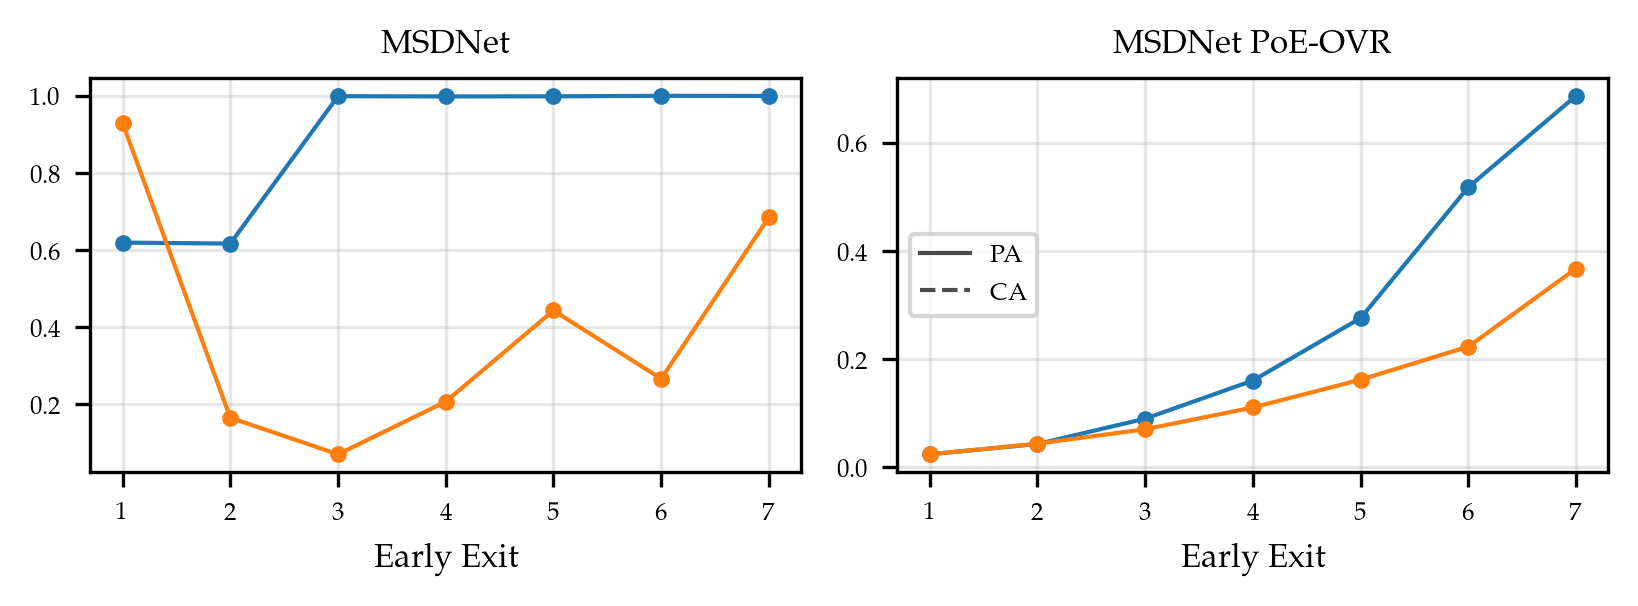

In [54]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})

PLOT_TYPE = 'Modal Probability'
# PLOT_TYPE = 'Ground-Truth Probability'

fig, ax = plt.subplots(1, 2, figsize=(text_width, text_width * 3/8))
early_exits = [i + 1 for i in range(L)]

ax[0].set_xlabel('Early Exit')
# ax[0].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
        probs_i = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[0].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[0].set_xticks(early_exits)
ax[0].set_title('MSDNet')


ax[1].set_xlabel('Early Exit')
# ax[1].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
        probs_i = probs_poe_ovr_break_ties_generalized[:, i, preds_poe_ovr_break_ties_generalized[L - 1][i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[1].set_xticks(early_exits)
ax[1].set_title('MSDNet PoE-OVR')

plt.tight_layout()
# plt.savefig(f'figures/figure_3_{PLOT_TYPE}.pdf', dpi=1200, bbox_inches='tight')
plt.show()

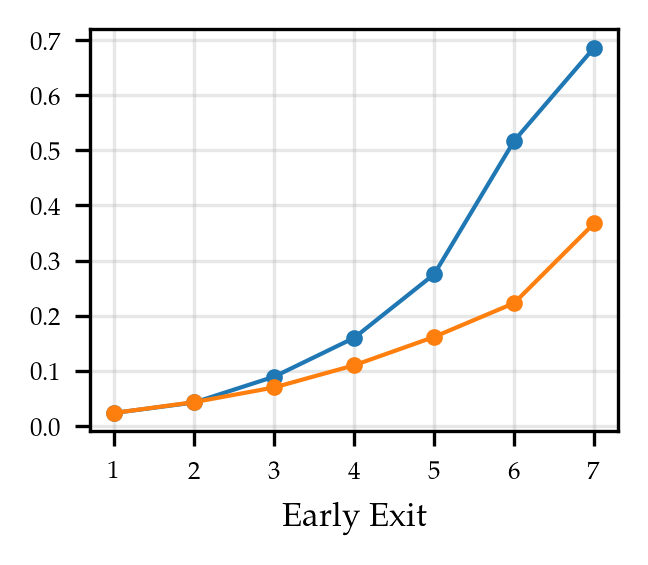

In [26]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})

PLOT_TYPE = 'modal_probability'
# PLOT_TYPE = 'Ground-Truth Probability'

fig, ax = plt.subplots(1, 1, figsize=(text_width * 0.4, text_width/2 * 3.5/5))
early_exits = [i + 1 for i in range(L)]

plt.xlabel('Early Exit')
# ax[0].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'modal_probability':
    for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
        # probs_i = probs[:, i, preds[L - 1][i]].cpu()
        # plt.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
        probs_i = probs_poe_ovr_break_ties_generalized[:, i, preds_poe_ovr_break_ties_generalized[L - 1][i]].cpu()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
        probs_i = probs[:, i, targets[i]].cpu()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')


plt.tight_layout()
plt.savefig(f'figures/figure_3_{PLOT_TYPE}_half.pdf', dpi=1200, bbox_inches='tight')
plt.show()

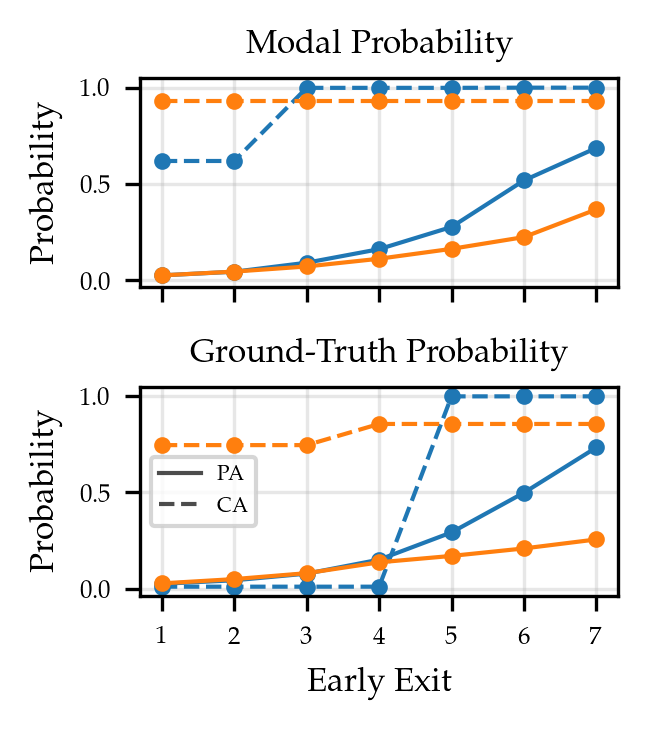

In [60]:
# FONT_SIZE = 12

fig, axs = plt.subplots(2, 1, figsize=(text_width * 0.4, text_width * 0.45), sharey=True, sharex=True)
early_exits = [i + 1 for i in range(L)]


# ax[0].set_ylabel(PLOT_TYPE)

for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
    # probs_i = probs[:, i, preds[L - 1][i]].cpu()
    # plt.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
    probs_i = probs_poe_ovr_break_ties_generalized[:, i, preds_poe_ovr_break_ties_generalized[L - 1][i]].cpu()
    probs_i_caching = probs_stateful[:, i, preds_stateful[L - 1][i]].cpu()
    axs[0].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color, label='PA')
    axs[0].plot(list(range(1, len(probs_i_caching) + 1)), probs_i_caching, marker='o', color=color, linestyle='--', label='CA')


# axs[0].set_xlabel('Early Exit')
axs[0].set_ylabel('Probability')
axs[0].set_title('Modal Probability')
axs[0].set_xticks(early_exits)

for i, color in zip([4969, 6534], ['tab:blue', 'tab:orange']):
    # probs_i = probs[:, i, targets[i]].cpu()
    # axs[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
    probs_i = probs_poe_ovr_break_ties_generalized[:, i, targets[i]].cpu()
    probs_i_caching = probs_stateful[:, i, targets[i]].cpu()
    axs[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color, label='PA')
    axs[1].plot(list(range(1, len(probs_i_caching) + 1)), probs_i_caching, marker='o', linestyle='--', color=color, label='CA')

axs[1].set_xlabel('Early Exit')
axs[1].set_ylabel('Probability')
axs[1].set_title('Ground-Truth Probability')

lines = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', alpha=0.7),
]
labels = ['PA', 'CA']
axs[1].legend(lines, labels, loc='center left', fontsize=5)

plt.tight_layout()
plt.savefig(f'figures/figure_3_joined_half_caching_baseline.pdf', dpi=1200, bbox_inches='tight')
plt.show()

# Figure 4

In [28]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [29]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [30]:
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

In [31]:
scaled_dict = get_scale_probs(['PoE-OVR (tempered)'], [probs_poe_ovr_break_ties_generalized], [2.], targets, C=ARGS.num_classes, L=L)
probs_poe_ovr_break_ties_generalized_tempered = scaled_dict['PoE-OVR (tempered)'][2.0][0]

In [32]:
_probs_poe_ovr_break_ties_generalized_tempered = temper_probs(probs_poe_ovr_break_ties_generalized, .5)
_probs_poe_ovr_break_ties_generalized_tempered_multi = temper_probs(
    probs_poe_ovr_break_ties_generalized,
    np.array([0.20, 0.25 ,0.30, 0.35, 0.4, 0.45, 0.5])[:, None, None]).to(torch.float32)

In [33]:
logits_poe = logits.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

In [34]:
random.seed(10)
CALIB_SIZE = 0.2
ALPHA = 0.05
calib_ids = random.sample(range(N), int(CALIB_SIZE * N))
valid_ids = list(set(range(N)) - set(calib_ids))

# sizes_conf_sets,_ = conformalize_anytime_nn(probs.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe,_ = conformalize_anytime_nn(probs_poe.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe_ovr_break_ties_generalized, _ = conformalize_anytime_nn(probs_poe_ovr_break_ties_generalized.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, _ = conformalize_anytime_nn(probs_poe_ovr_break_ties_generalized_tempered.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
sizes_conf_sets,_ = conformalize_anytime_nn_raps(probs.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe,_ = conformalize_anytime_nn_raps(probs_poe.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe_ovr_break_ties_generalized, _ = conformalize_anytime_nn_raps(probs_poe_ovr_break_ties_generalized.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, _ = conformalize_anytime_nn_raps(_probs_poe_ovr_break_ties_generalized_tempered.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe_ovr_break_ties_generalized_tempered_multi, _ = conformalize_anytime_nn_raps(_probs_poe_ovr_break_ties_generalized_tempered_multi.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)

1 1.0324929980975721
2 1.0195449964975698
3 1.010824835721305
4 1.0076205733814623
5 1.0110751561137006
6 1.016485761184303
7 1.0194407895404107
1 1.032164740179095
2 0.9984557576387849
3 0.9987043405566113
4 0.9989350273192706
5 0.999220756994655
6 0.9990251785680488
7 0.9988836663841492
1 0.28856089396136714
2 0.28148119748446604
3 0.3727318367783411
4 0.48952006730685776
5 0.6395963118389898
6 0.7726161506953443
7 0.8917985669801565
1 0.3224457868267028
2 0.3821150802890932
3 0.549952482104689
4 0.7429939506647315
5 0.883867225571166
6 0.9599821783687809
7 0.9941407841523935
1 0.42596446316605385
2 0.5539300771176714
3 0.7439306900814633
4 0.846494870597701
5 0.9458120559142192
6 0.9769661493359086
7 0.9947689829869519


In [35]:
entropy_baseline = scipy.stats.entropy(probs.numpy(), axis=2)
entropy_poe = scipy.stats.entropy(probs_poe.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized = scipy.stats.entropy(probs_poe_ovr_break_ties_generalized.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized_tempered = scipy.stats.entropy(_probs_poe_ovr_break_ties_generalized_tempered.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized_tempered_multi = scipy.stats.entropy(_probs_poe_ovr_break_ties_generalized_tempered_multi.numpy(), axis=2)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-04-05 22:47:47.667246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 22:47:47.668972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20695 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


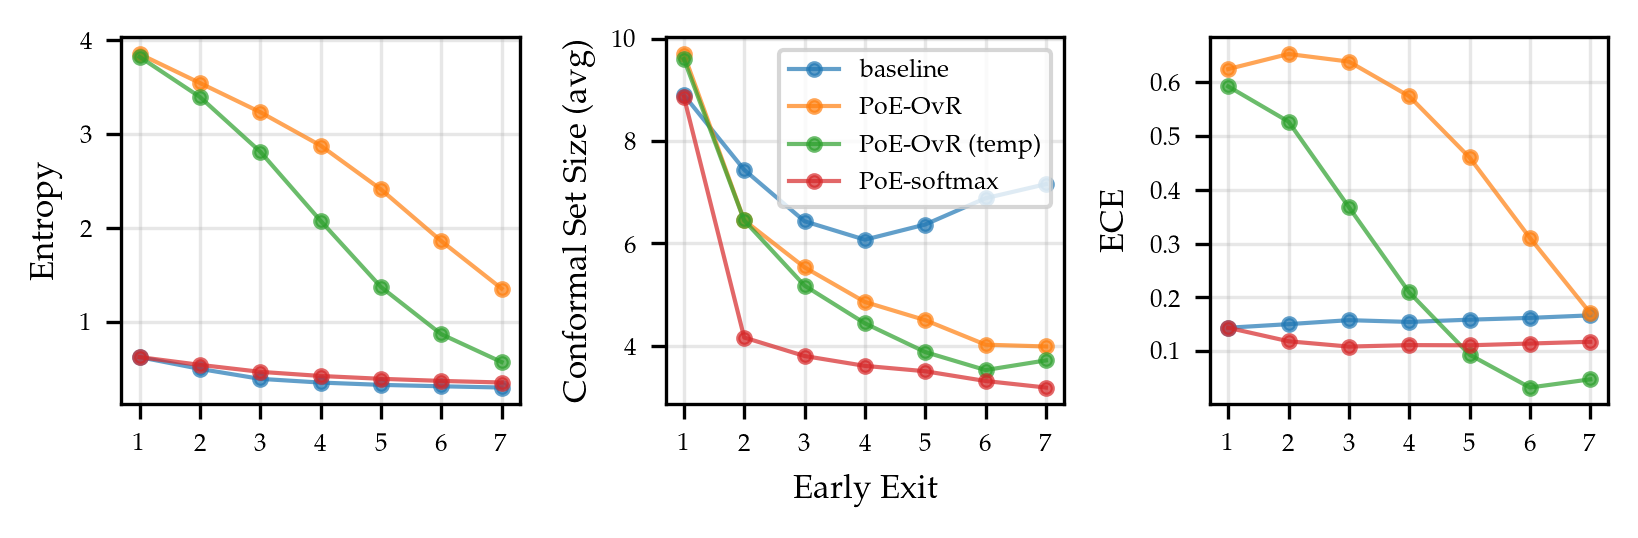

In [36]:
NAMES = [
    'baseline',
    'PoE-OvR',
    # 'MSDNet PoE-OvR (tempered)',
    'PoE-OvR (temp)',
    'PoE-softmax',
]
COLORS = [
    'tab:blue',
    'tab:orange',
    # 'tab:green',
    'tab:green',
    'tab:red',
]
PROBS = [
    probs,
    probs_poe_ovr_break_ties_generalized,
    # _probs_poe_ovr_break_ties_generalized_tempered,
    _probs_poe_ovr_break_ties_generalized_tempered_multi,
    probs_poe,
]

fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width * 4 / 12), sharex=True)

for _entropy, label, color in zip([entropy_baseline, entropy_poe_ovr_break_ties_generalized, entropy_poe_ovr_break_ties_generalized_tempered, entropy_poe, entropy_poe_ovr_break_ties_generalized_tempered_multi], NAMES, COLORS):
    ax[0].plot(list(range(1, L + 1)), _entropy.mean(axis=1), marker='o', label=label, color=color, alpha=0.7)
# ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Entropy')


for _sizes, label, color in zip([sizes_conf_sets, sizes_conf_sets_poe_ovr_break_ties_generalized, sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, sizes_conf_sets_poe, sizes_conf_sets_poe_ovr_break_ties_generalized_tempered_multi], NAMES, COLORS):
    ax[1].plot(list(range(1, L + 1)), _sizes, marker='o', label=label, color=color, alpha=0.7)
ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel('Conformal Set Size (avg)')
ax[1].set_xticks(list(range(1, L + 1)))


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    eces = []
    eces_rm = []
    for l in range(L):
        # eces.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
        ece = rm.metrics.ExpectedCalibrationError(num_bins=15)
        ece.add_batch(_probs[l, :, :].numpy(), label=targets.numpy())
        eces_rm.append(ece.result()['ece'])
    # ax[2].plot(list(range(1, L + 1)), eces, '-', marker='o', label=label, color=color, alpha=0.5)
    ax[2].plot(list(range(1, L + 1)), eces_rm, '-', marker='o', label=label, color=color, alpha=0.7)
# ax[2].set_xlabel('Early Exit')
ax[2].set_ylabel('ECE')

ax[1].legend()



plt.tight_layout()
plt.savefig(f'figures/figure_4_raps.pdf', dpi=1200, bbox_inches='tight')
plt.show()

# Figure Categorical likelihoods

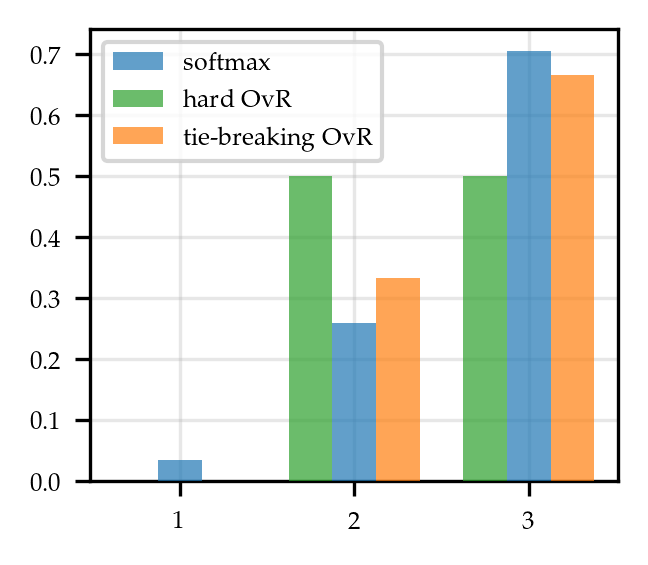

In [37]:
a = torch.tensor([-1., 1., 2.])
b = torch.softmax(a, dim=0).numpy()
c = (torch.sigmoid(a).round() / 2).numpy()
d = torch.tensor([0., 1/3, 2/3])
x = np.arange(1, 4, 1)

fig, ax = plt.subplots(figsize=(text_width * 0.4, text_width/2 * 0.7))
plt.bar(x, b, width=0.25, color='tab:blue', align='center', label='softmax', zorder=5, alpha=0.7)
plt.bar(x-0.25, c, width=0.25, color='tab:green', align='center', label='hard OvR', zorder=5, alpha=0.7)
plt.bar(x+0.25, d, width=0.25, color='tab:orange', align='center', label='tie-breaking OvR', zorder=5, alpha=0.7)
plt.xticks(x, [1, 2, 3])
plt.legend()
plt.grid(alpha=0.3, zorder=-5)
plt.savefig(f'figures/figure_likelihoods.pdf', dpi=1200, bbox_inches='tight')
plt.show()

# Figure Appendix CIFAR-10

In [39]:
CIFAR_10_DICT = {"MSDNet": [0.833, 0.8575, 0.8733, 0.8768, 0.8779, 0.8687, 0.8692], 
                  "MSDNet-PA": [0.833, 0.8627, 0.8803, 0.8857, 0.8881, 0.884, 0.8838], 
                  "MSDNet-CA": [0.833, 0.8594, 0.8756, 0.8815, 0.8845, 0.8823, 0.8812],
                  "IMTA": [0.89, 0.9064, 0.9181, 0.9201, 0.9237, 0.9258, 0.9259], 
                  "IMTA-PA": [0.89, 0.9033, 0.9131, 0.9186, 0.9215, 0.9227, 0.9252],
                  "IMTA-CA": [0.89, 0.901, 0.9098, 0.9147, 0.9182, 0.9191, 0.9199],
                  "DViT": [0.9636, 0.9744, 0.9809],
                  "DViT-PA": [0.9636, 0.9742, 0.9786],
                  "DViT-CA": [0.9636, 0.9725, 0.9773],
                }



THRESHOLDS = [-x for x in [-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5]]

# UPDATED RESULTS: April 2023
CIFAR_10_DICT_MONO = {"MSDNet": [70.47, 45.98, 34.5, 28.6, 21.15, 18.16, 14.02, 7.43], 
                  "MSDNet-PA": [5.47, 3.73, 0.98, 0.25, 0.05, 0.03, 0.01, 0.01], 
                  "MSDNet-CA": [4.13, 4.0, 3.57, 3.12, 2.3, 2.05, 1.59, 0.85],
                  "IMTA": [47.04, 19.98, 12.82, 9.83, 5.62, 4.55, 3.0, 1.0], 
                  "IMTA-PA": [1.99, 1.24, 0.27, 0.01, 0.0, 0.0, 0.0, 0.0],
                  "IMTA-CA": [1.08, 1.01, 0.86, 0.69, 0.44, 0.33, 0.2, 0.08],
                  "DViT": [37.6, 4.63, 2.65, 1.83, 1.04, 0.79, 0.54, 0.13],
                  "DViT-PA": [0.43, 0.27, 0.06, 0.03, 0.0, 0.0, 0.0, 0.0],
                  "DViT-CA": [0.17, 0.16, 0.13, 0.1, 0.07, 0.05, 0.02, 0.0],
                }

In [40]:
COLOR_DICT = {"MSDNet": "tab:blue", "IMTA": "tab:green", "DViT": "tab:orange"}

colors = {'MSDNet': 'tab:blue', 'MSDNet-PA': 'tab:blue', 'MSDNet-CA': 'tab:blue', 
          'IMTA': 'tab:green', 'IMTA-PA': 'tab:green', 'IMTA-CA': 'tab:green', 
          'DViT': 'tab:orange', 'DViT-PA': 'tab:orange', 'DViT-CA': 'tab:orange'}
line_styles = {'MSDNet': '-', 'MSDNet-PA': '--', 'MSDNet-CA': '--', 
               'IMTA': '-', 'IMTA-PA': '--', 'IMTA-CA': '--',
               'DViT': '-', 'DViT-PA': '--', 'DViT-CA': '--'}
marker_styles = {'MSDNet': 'o', 'MSDNet-PA': 'x', 'MSDNet-CA': '^', 
                 'IMTA': 'o', 'IMTA-PA': 'x', 'IMTA-CA': '^', 
                 'DViT': 'o', 'DViT-PA': 'x', 'DViT-CA': '^'}

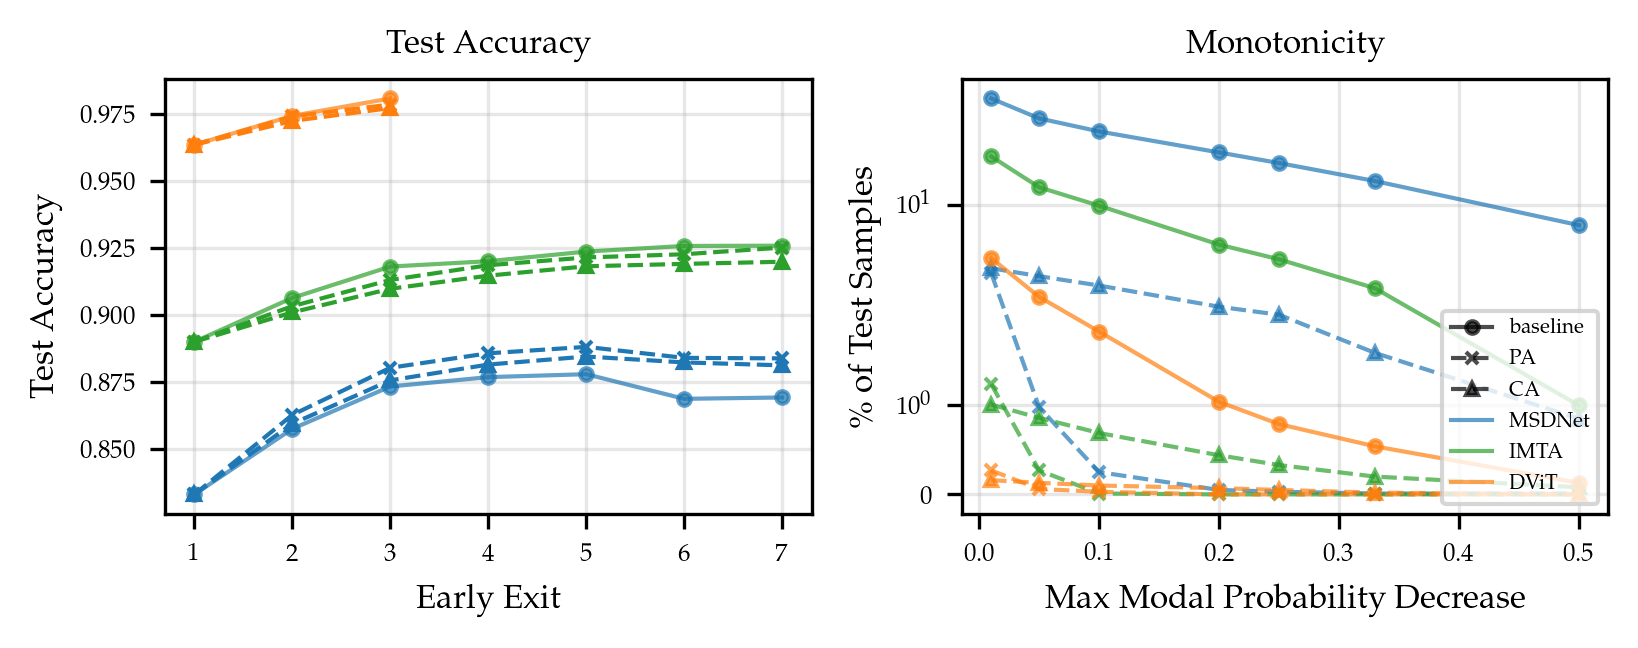

In [41]:
# sns.set_theme()
# FONT_SIZE = 11
# plt.rcParams.update({'font.size': FONT_SIZE})

fig, ax = plt.subplots(1, 2, figsize=(text_width, 0.4*text_width))

ax[0].plot(list(range(1, len(CIFAR_10_DICT["MSDNet"]) + 1)), CIFAR_10_DICT["MSDNet"], label='MSDNet', marker='o', color=COLOR_DICT["MSDNet"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_10_DICT["MSDNet-PA"]) + 1)), CIFAR_10_DICT["MSDNet-PA"], label='MSDNet-PA', marker='x', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["MSDNet-CA"]) + 1)), CIFAR_10_DICT["MSDNet-CA"], label='MSDNet-CA', marker='^', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["IMTA"]) + 1)), CIFAR_10_DICT["IMTA"], label='IMTA', marker='o', color=COLOR_DICT["IMTA"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_10_DICT["IMTA-PA"]) + 1)), CIFAR_10_DICT["IMTA-PA"], label='IMTA-PA', marker='x', color=COLOR_DICT["IMTA"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["IMTA-CA"]) + 1)), CIFAR_10_DICT["IMTA-CA"], label='IMTA-CA', marker='^', color=COLOR_DICT["IMTA"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["DViT"]) + 1)), CIFAR_10_DICT["DViT"], label='DViT', marker='o', color=COLOR_DICT["DViT"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_10_DICT["DViT-PA"]) + 1)), CIFAR_10_DICT["DViT-PA"], label='DViT-PA', marker='x', color=COLOR_DICT["DViT"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["DViT-CA"]) + 1)), CIFAR_10_DICT["DViT-CA"], label='DViT-CA', marker='^', color=COLOR_DICT["DViT"], linestyle='--')
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Test Accuracy')
ax[0].set_title('Test Accuracy')
ax[0].set_xticks([x for x in range(1, 8)])
# ax[0].legend()

for name, percentages in CIFAR_10_DICT_MONO.items():
    ax[1].plot(THRESHOLDS[1:], percentages[1:], marker=marker_styles[name], label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

ax[1].set_xlabel('Max Modal Probability Decrease')
ax[1].set_ylabel('\% of Test Samples')
# ax[0].legend()
# set log scale
ax[1].set_yscale('symlog')
ax[1].set_title('Monotonicity')

# construct a legend with different line styles
lines = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', marker='o', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='x', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='^', alpha=0.7),
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.7),
]
labels = ['baseline', 'PA', 'CA', 'MSDNet', 'IMTA', 'DViT']
ax[1].legend(lines, labels, loc='lower right', fontsize=5)


plt.tight_layout()
plt.savefig(f'figures/figure_cifar_10_results_appendix.pdf', bbox_inches='tight')
plt.show()

# Figure Appendix Ground-Truth Probability Monotonicity

In [94]:

THRESHOLDS = [-x for x in [-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5]]

# CIFAR_10_DICT = {'MSDNet': [70.62, 46.06, 34.8, 29.03, 22.42, 19.79, 16.17, 10.31],
#                 'MSDNet-PA': [13.59, 12.24, 9.39, 7.34, 2.86, 1.45, 0.38, 0.03],
#                 'MSDNet-CA': [12.02, 10.79, 8.7, 7.49, 5.76, 5.17, 4.38, 3.13],
#                   'IMTA': [47.35, 20.17, 12.9, 10.0, 6.53, 5.56, 4.26, 2.34],
#                   'IMTA-PA': [7.81, 7.16, 5.78, 4.83, 2.72, 1.36, 0.39, 0.0],
#                   'IMTA-CA': [5.73, 4.29, 3.23, 2.57, 1.94, 1.69, 1.42, 0.87],
#                   'DViT': [38.04, 5.1, 3.09, 2.24, 1.49, 1.22, 0.93, 0.56],
#                   'DViT-PA': [1.74, 1.57, 1.17, 0.81, 0.29, 0.13, 0.05, 0.0],
#                   'DViT-CA': [1.3, 1.06, 0.83, 0.71, 0.54, 0.48, 0.35, 0.29],
#                 }

# CIFAR_100_DICT = {"MSDNet": [86.63, 66.1, 54.18, 48.26, 40.33, 37.19, 33.08, 24.83], 
#                   "MSDNet-PA": [13.01, 10.08, 1.11, 0.05, 0.0, 0.0, 0.0, 0.0], 
#                   "MSDNet-CA": [26.09, 21.09, 16.48, 13.78, 10.9, 9.87, 8.78, 6.72],
#                   'IMTA': [74.79, 51.15, 38.96, 33.12, 25.96, 23.39, 19.72, 13.32],
#                   'IMTA-PA': [16.14, 13.2, 2.06, 0.12, 0.0, 0.0, 0.0, 0.0],
#                   'IMTA-CA': [22.96, 16.89, 11.9, 9.97, 7.46, 6.68, 5.66, 3.97],
#                   'DViT': [70.64, 35.41, 23.24, 17.38, 10.98, 9.12, 6.59, 2.77],
#                   'DViT-PA': [0.9, 0.51, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                   'DViT-CA': [7.42, 6.46, 5.16, 4.1, 2.74, 2.29, 1.67, 0.71]
#                 }


# IMAGE_NET_DICT = {'MSDNet': [86.55, 68.232, 47.87, 34.574, 18.696, 13.606, 8.21, 2.25],
#                   'MSDNet-PA': [1.85, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                   'MSDNet-CA': [19.678, 14.94, 9.648, 6.464, 3.238, 2.338, 1.344, 0.344],
#                   'IMTA': [82.24, 60.814, 40.944, 29.096, 15.462, 11.318, 6.688, 1.864],
#                   'IMTA-PA': [1.746, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                   'IMTA-CA': [19.558, 14.512, 9.326, 6.332, 3.08, 2.198, 1.252, 0.332],
#                   'DViT': [60.22, 51.172, 28.226, 13.204, 3.798, 2.23, 0.954, 0.112],
#                   'DViT-PA': [0.778, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                   'DViT-CA': [11.548, 8.426, 4.774, 2.692, 0.942, 0.568, 0.232, 0.024],
#                 }

# Updated results: May 2023
CIFAR_10_DICT = {'MSDNet': [44.12, 24.35, 17.81, 15.05, 12.13, 10.95, 9.58, 6.73],
  'MSDNet-PA': [8.09, 7.32, 5.79, 4.85, 2.66, 1.59, 0.46, 0.02],
  'MSDNet-CA': [6.24, 4.99, 4.03, 3.44, 2.85, 2.61, 2.32, 1.84],
                  'IMTA': [47.35, 20.17, 12.9, 10.0, 6.53, 5.56, 4.26, 2.34],
                  'IMTA-PA': [7.81, 7.16, 5.78, 4.83, 2.72, 1.36, 0.39, 0.0],
                  'IMTA-CA': [5.73, 4.29, 3.23, 2.57, 1.94, 1.69, 1.42, 0.87],
                  'DViT': [38.04, 5.1, 3.09, 2.24, 1.49, 1.22, 0.93, 0.56],
                  'DViT-PA': [1.74, 1.57, 1.17, 0.81, 0.29, 0.13, 0.05, 0.0],
                  'DViT-CA': [1.3, 1.06, 0.83, 0.71, 0.54, 0.48, 0.35, 0.29],
                }

CIFAR_100_DICT = {'MSDNet': [86.46, 66.09, 54.21, 47.75, 40.24, 37.29, 32.88, 24.8],
  'MSDNet-PA': [13.06, 10.05, 1.1, 0.05, 0.0, 0.0, 0.0, 0.0],
  'MSDNet-CA': [25.88, 20.93, 16.72, 13.86, 10.59, 9.88, 8.62, 6.6],
                  'IMTA': [74.79, 51.15, 38.96, 33.12, 25.96, 23.39, 19.72, 13.32],
                  'IMTA-PA': [16.14, 13.2, 2.06, 0.12, 0.0, 0.0, 0.0, 0.0],
                  'IMTA-CA': [22.96, 16.89, 11.9, 9.97, 7.46, 6.68, 5.66, 3.97],
                  'DViT': [70.64, 35.41, 23.24, 17.38, 10.98, 9.12, 6.59, 2.77],
                  'DViT-PA': [0.9, 0.51, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                  'DViT-CA': [7.42, 6.46, 5.16, 4.1, 2.74, 2.29, 1.67, 0.71]
                }


IMAGE_NET_DICT = {'MSDNet': [86.55, 68.232, 47.87, 34.574, 18.696, 13.606, 8.21, 2.25],
  'MSDNet-PA': [1.85, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'MSDNet-CA': [19.678, 14.94, 9.648, 6.464, 3.238, 2.338, 1.344, 0.344],
                  'IMTA': [82.24, 60.814, 40.944, 29.096, 15.462, 11.318, 6.688, 1.864],
                  'IMTA-PA': [1.746, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                  'IMTA-CA': [19.558, 14.512, 9.326, 6.332, 3.08, 2.198, 1.252, 0.332],
                  'DViT': [60.22, 51.172, 28.226, 13.204, 3.798, 2.23, 0.954, 0.112],
                  'DViT-PA': [0.778, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                  'DViT-CA': [11.548, 8.426, 4.774, 2.692, 0.942, 0.568, 0.232, 0.024],
                }

SELECTED_THRESHOLDS = [0.01, 0.1, 0.25]

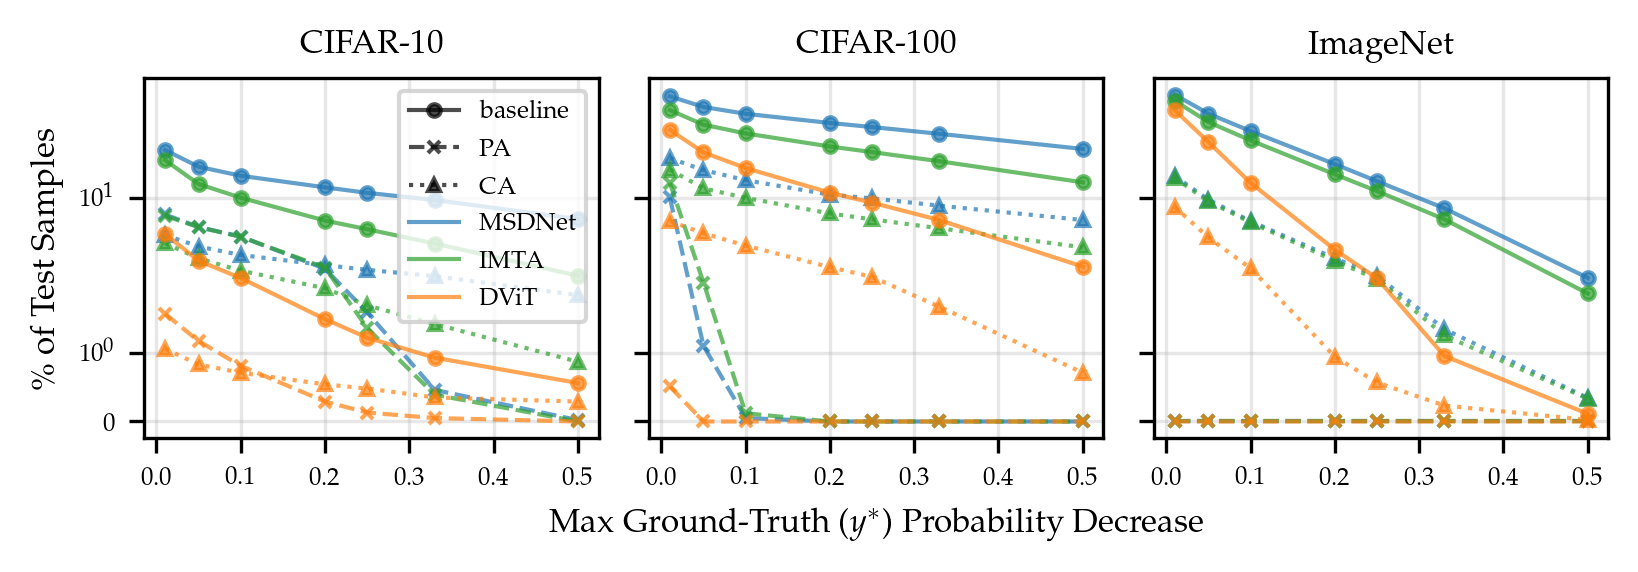

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width * 4.25/12), sharex=True, sharey=True)

colors = {'MSDNet': 'tab:blue', 'MSDNet-PA': 'tab:blue', 'MSDNet-CA': 'tab:blue', 
          'IMTA': 'tab:green', 'IMTA-PA': 'tab:green', 'IMTA-CA': 'tab:green', 
          'DViT': 'tab:orange', 'DViT-PA': 'tab:orange', 'DViT-CA': 'tab:orange'}
line_styles = {'MSDNet': '-', 'MSDNet-PA': '--', 'MSDNet-CA': 'dotted', 
               'IMTA': '-', 'IMTA-PA': '--', 'IMTA-CA': 'dotted',
               'DViT': '-', 'DViT-PA': '--', 'DViT-CA': 'dotted'}
marker_styles = {'MSDNet': 'o', 'MSDNet-PA': 'x', 'MSDNet-CA': '^', 
                 'IMTA': 'o', 'IMTA-PA': 'x', 'IMTA-CA': '^', 
                 'DViT': 'o', 'DViT-PA': 'x', 'DViT-CA': '^'}

for name, percentages in CIFAR_10_DICT.items():
    ax[0].plot(THRESHOLDS[1:], percentages[1:], marker=marker_styles[name], label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

# ax[0].set_xlabel('Max Probability Decrease')
ax[0].set_ylabel('\% of Test Samples')
# ax[0].legend()
# set log scale
ax[0].set_yscale('symlog')
ax[0].set_title('CIFAR-10')

for name, percentages in CIFAR_100_DICT.items():
    ax[1].plot(THRESHOLDS[1:], percentages[1:], marker=marker_styles[name], label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

ax[1].set_xlabel('Max Ground-Truth ($y^*$) Probability Decrease')
# ax[1].set_ylabel('\% of Test Samples')
# ax[1].legend()
# set log scale
ax[1].set_yscale('symlog')
ax[1].set_title('CIFAR-100')

for name, percentages in IMAGE_NET_DICT.items():
    ax[2].plot(THRESHOLDS[1:], percentages[1:], marker=marker_styles[name], label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

# ax[2].set_xlabel('Max Probability Decrease')
# ax[2].set_ylabel('\% of Test Samples')
# ax[2].legend()
# set log scale
ax[2].set_yscale('symlog')
ax[2].set_title('ImageNet')
# ax[2].set_xticks(THRESHOLDS)

# construct a legend with different line styles
lines = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', marker='o', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='x', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='dotted', marker='^', alpha=0.7),
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.7),
]
labels = ['baseline', 'PA', 'CA', 'MSDNet', 'IMTA', 'DViT']
ax[0].legend(lines, labels, loc='upper right')

plt.tight_layout()
# plt.savefig(f'figures/figure_ground_truth_cond_mono.pdf', dpi=1200, bbox_inches='tight')
plt.show()

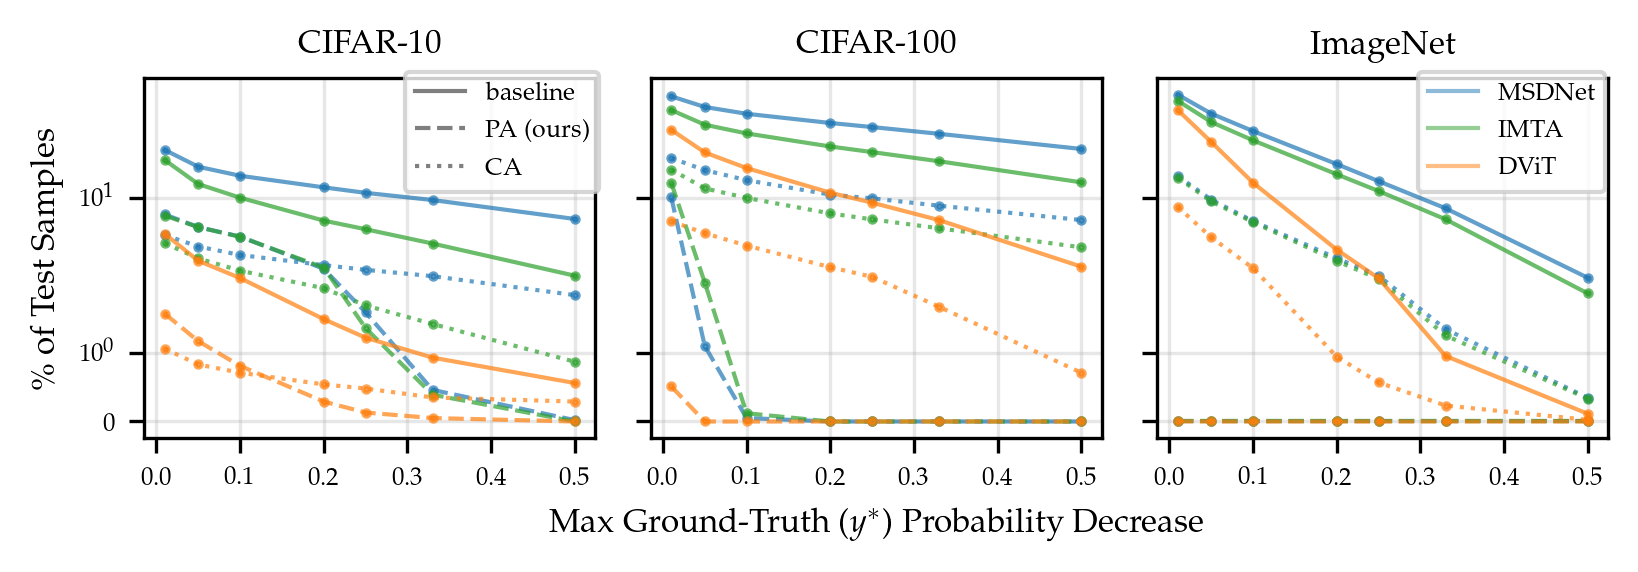

In [96]:
fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width * 4.25/12), sharex=True, sharey=True)

colors = {'MSDNet': 'tab:blue', 'MSDNet-PA': 'tab:blue', 'MSDNet-CA': 'tab:blue', 
          'IMTA': 'tab:green', 'IMTA-PA': 'tab:green', 'IMTA-CA': 'tab:green', 
          'DViT': 'tab:orange', 'DViT-PA': 'tab:orange', 'DViT-CA': 'tab:orange'}
line_styles = {'MSDNet': '-', 'MSDNet-PA': '--', 'MSDNet-CA': 'dotted', 
               'IMTA': '-', 'IMTA-PA': '--', 'IMTA-CA': 'dotted',
               'DViT': '-', 'DViT-PA': '--', 'DViT-CA': 'dotted'}
marker_styles = {'MSDNet': 'o', 'MSDNet-PA': 'x', 'MSDNet-CA': '^', 
                 'IMTA': 'o', 'IMTA-PA': 'x', 'IMTA-CA': '^', 
                 'DViT': 'o', 'DViT-PA': 'x', 'DViT-CA': '^'}

for name, percentages in CIFAR_10_DICT.items():
    ax[0].plot(THRESHOLDS[1:], percentages[1:], marker='o', markersize=1.5, label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

# ax[0].set_xlabel('Max Probability Decrease')
ax[0].set_ylabel('\% of Test Samples')
# ax[0].legend()
# set log scale
ax[0].set_yscale('symlog')
ax[0].set_title('CIFAR-10')

for name, percentages in CIFAR_100_DICT.items():
    ax[1].plot(THRESHOLDS[1:], percentages[1:], marker='o', markersize=1.5, label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

ax[1].set_xlabel('Max Ground-Truth ($y^*$) Probability Decrease')
# ax[1].set_ylabel('\% of Test Samples')
# ax[1].legend()
# set log scale
ax[1].set_yscale('symlog')
ax[1].set_title('CIFAR-100')

for name, percentages in IMAGE_NET_DICT.items():
    ax[2].plot(THRESHOLDS[1:], percentages[1:], marker='o', markersize=1.5, label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

# ax[2].set_xlabel('Max Probability Decrease')
# ax[2].set_ylabel('\% of Test Samples')
# ax[2].legend()
# set log scale
ax[2].set_yscale('symlog')
ax[2].set_title('ImageNet')
# ax[2].set_xticks(THRESHOLDS)

lines1 = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='black', lw=1, linestyle='--', alpha=0.5),
    Line2D([0], [0], color='black', lw=1, linestyle='dotted', alpha=0.5),
]
labels1 = [
    "baseline",
    "PA (ours)",
    "CA"
]

lines2 = [
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.5),
]
labels2 = [
    "MSDNet",
    "IMTA",
    "DViT",
]

legend1 = ax[0].legend(lines1, labels1, loc='lower left', bbox_to_anchor=(0.55, 0.65))
legend2 = ax[2].legend(lines2, labels2, loc='lower left', bbox_to_anchor=(0.55, 0.65))

plt.tight_layout()
plt.savefig(f'figures/figure_ground_truth_cond_mono_v2.pdf', dpi=1200, bbox_inches='tight')
plt.show()

# Figure NLP experiments

results copied from: https://github.com/metodj/sledgehammer/tree/guarantees

In [5]:
THRESHOLDS = [-x for x in [-0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5]]

ACC_DICT = {'IMDB': [0.8282, 0.8698, 0.8862, 0.9008],
            'IMDB-PA': [0.8282, 0.8699, 0.8864, 0.901],
            'IMDB-CA': [0.8282, 0.8616, 0.8747, 0.8872],
            'AG': [0.9172, 0.9262, 0.9262, 0.9254],
            'AG-PA': [0.9172, 0.9254, 0.9262, 0.9263],
            'AG-CA': [0.9172, 0.925, 0.9258, 0.9261],
            'SNLI': [0.7376, 0.8631, 0.8633, 0.8636],
            'SNLI-PA': [0.7376, 0.8443, 0.848, 0.8519],
            'SNLI-CA': [0.7376, 0.8492, 0.851, 0.852]

                }


MONO_DICT = {'IMDB': [40.88, 25.68, 16.904, 8.156, 5.476, 2.572, 0.464],
            'IMDB-PA': [7.44, 6.644, 6.016, 5.28, 5.092, 4.812, 3.332],
            'IMDB-CA': [1.06, 0.812, 0.588, 0.272, 0.184, 0.1, 0.024],
            'AG': [32.4079, 11.8421, 5.5921, 1.7368, 0.9079, 0.3684, 0.0526],
            'AG-PA': [1.0526, 0.25, 0.0658, 0.0132, 0.0132, 0.0, 0.0],
            'AG-CA': [0.0921, 0.0789, 0.0, 0.0, 0.0, 0.0, 0.0],
            'SNLI': [47.6792, 12.8156, 5.9752, 2.0053, 1.2215, 0.509, 0.0814],
            'SNLI-PA': [7.1458, 2.0969, 0.6515, 0.1934, 0.1425, 0.1221, 0.1221],
            'SNLI-CA': [0.0509, 0.0204, 0.0102, 0.0, 0.0, 0.0, 0.0]
                }


GROUND_TRUTH_DICT = {'IMDB': [42.736, 27.648, 19.116, 10.512, 7.936, 5.024, 1.74],
                    'IMDB-PA': [10.112, 9.472, 8.956, 8.288, 8.1, 7.788, 5.908],
                    'IMDB-CA': [7.78, 6.34, 5.044, 3.148, 2.488, 1.732, 0.72],
                    'AG': [32.7105, 12.2632, 6.3684, 2.5132, 1.5921, 0.9474, 0.2105],
                    'AG-PA': [6.4211, 5.5526, 4.8947, 3.6711, 3.1316, 2.0658, 0.0789],
                    'AG-CA': [3.5789, 2.4737, 1.6579, 0.8421, 0.5395, 0.3158, 0.0526],
                    'SNLI': [51.2622, 17.3962, 10.2097, 5.059, 3.8477, 2.331, 0.855],
                    'SNLI-PA': [10.7085, 5.9548, 4.4585, 3.5729, 3.2064, 2.7077, 1.4353],
                    'SNLI-CA': [8.123, 6.3314, 4.8147, 2.728, 2.1274, 1.3538, 0.4886]

}

In [6]:
COLOR_DICT = {"IMDB": "tab:blue", "AG": "tab:green", "SNLI": "tab:orange"}

colors = {'IMDB': 'tab:blue', 'IMDB-PA': 'tab:blue', 'IMDB-CA': 'tab:blue', 
          'AG': 'tab:green', 'AG-PA': 'tab:green', 'AG-CA': 'tab:green', 
          'SNLI': 'tab:orange', 'SNLI-PA': 'tab:orange', 'SNLI-CA': 'tab:orange'}
line_styles = {'IMDB': '-', 'IMDB-PA': '--', 'IMDB-CA': '--', 
               'AG': '-', 'AG-PA': '--', 'AG-CA': '--',
               'SNLI': '-', 'SNLI-PA': '--', 'SNLI-CA': '--'}
marker_styles = {'IMDB': 'o', 'IMDB-PA': 'x', 'IMDB-CA': '^', 
                 'AG': 'o', 'AG-PA': 'x', 'AG-CA': '^', 
                 'SNLI': 'o', 'SNLI-PA': 'x', 'SNLI-CA': '^'}

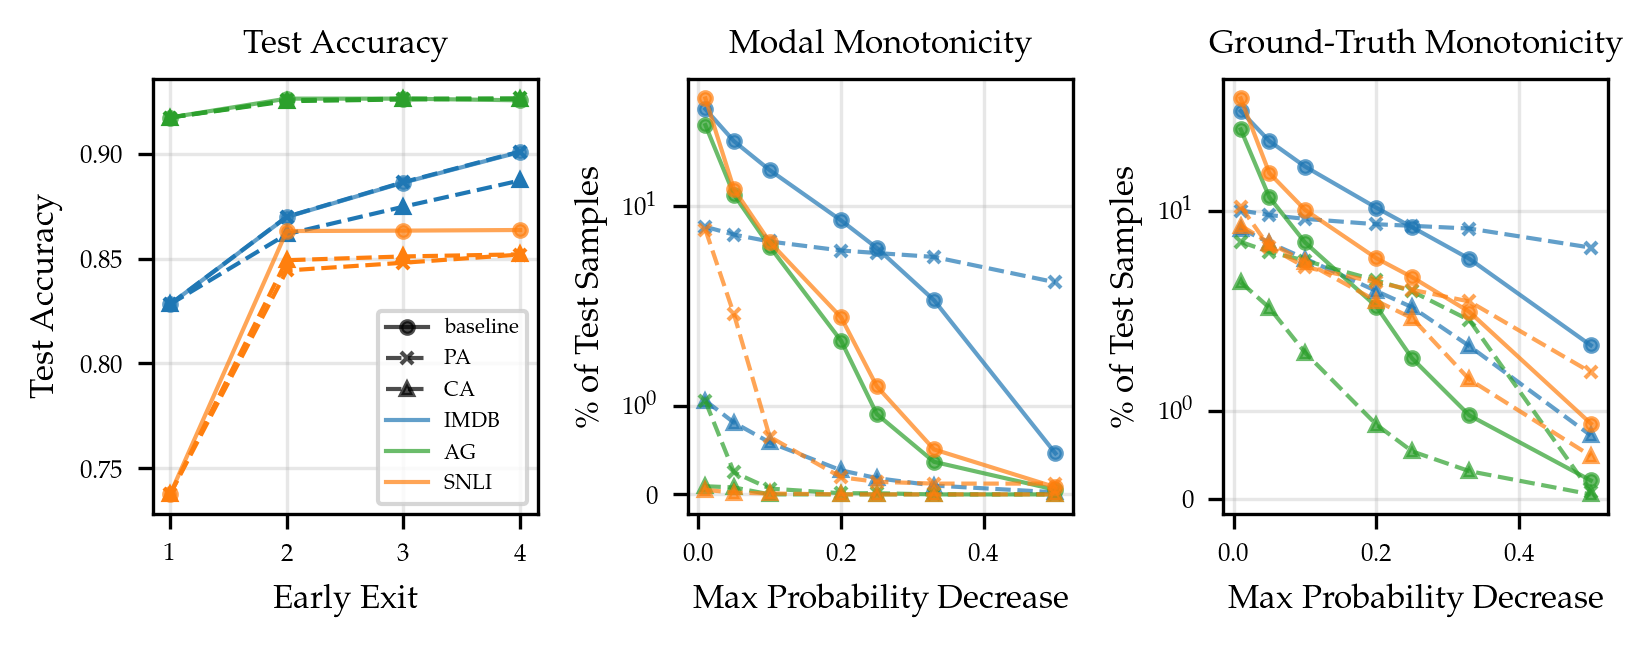

In [13]:
# sns.set_theme()
# FONT_SIZE = 11
# plt.rcParams.update({'font.size': FONT_SIZE})

fig, ax = plt.subplots(1, 3, figsize=(text_width, 0.4*text_width))

ax[0].plot(list(range(1, len(ACC_DICT["IMDB"]) + 1)), ACC_DICT["IMDB"], label='IMDB', marker='o', color=COLOR_DICT["IMDB"], alpha=0.7)
ax[0].plot(list(range(1, len(ACC_DICT["IMDB-PA"]) + 1)), ACC_DICT["IMDB-PA"], label='IMDB-PA', marker='x', color=COLOR_DICT["IMDB"], linestyle='--')
ax[0].plot(list(range(1, len(ACC_DICT["IMDB-CA"]) + 1)), ACC_DICT["IMDB-CA"], label='IMDB-CA', marker='^', color=COLOR_DICT["IMDB"], linestyle='--')
ax[0].plot(list(range(1, len(ACC_DICT["AG"]) + 1)), ACC_DICT["AG"], label='AG', marker='o', color=COLOR_DICT["AG"], alpha=0.7)
ax[0].plot(list(range(1, len(ACC_DICT["AG-PA"]) + 1)), ACC_DICT["AG-PA"], label='AG-PA', marker='x', color=COLOR_DICT["AG"], linestyle='--')
ax[0].plot(list(range(1, len(ACC_DICT["AG-CA"]) + 1)), ACC_DICT["AG-CA"], label='AG-CA', marker='^', color=COLOR_DICT["AG"], linestyle='--')
ax[0].plot(list(range(1, len(ACC_DICT["SNLI"]) + 1)), ACC_DICT["SNLI"], label='SNLI', marker='o', color=COLOR_DICT["SNLI"], alpha=0.7)
ax[0].plot(list(range(1, len(ACC_DICT["SNLI-PA"]) + 1)), ACC_DICT["SNLI-PA"], label='SNLI-PA', marker='x', color=COLOR_DICT["SNLI"], linestyle='--')
ax[0].plot(list(range(1, len(ACC_DICT["SNLI-CA"]) + 1)), ACC_DICT["SNLI-CA"], label='SNLI-CA', marker='^', color=COLOR_DICT["SNLI"], linestyle='--')
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Test Accuracy')
ax[0].set_title('Test Accuracy')
ax[0].set_xticks([x for x in range(1, 5)])
# ax[0].legend()

for name, percentages in MONO_DICT.items():
    ax[1].plot(THRESHOLDS, percentages, marker=marker_styles[name], label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

ax[1].set_xlabel('Max Probability Decrease')
ax[1].set_ylabel('\% of Test Samples')
# set log scale
ax[1].set_yscale('symlog')
ax[1].set_title('Modal Monotonicity')


for name, percentages in GROUND_TRUTH_DICT.items():
    ax[2].plot(THRESHOLDS, percentages, marker=marker_styles[name], label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

ax[2].set_xlabel('Max Probability Decrease')
ax[2].set_ylabel('\% of Test Samples')
# set log scale
ax[2].set_yscale('symlog')
ax[2].set_title('Ground-Truth Monotonicity')



# construct a legend with different line styles
lines = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', marker='o', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='x', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='^', alpha=0.7),
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.7),
]
labels = ['baseline', 'PA', 'CA', 'IMDB', 'AG', 'SNLI']
ax[0].legend(lines, labels, loc='lower right', fontsize=5)


plt.tight_layout()
plt.savefig(f'figures/figure_nlp_results.pdf', bbox_inches='tight')
plt.show()

# Figure Overthinking Measure

results copied from branch `modified-softmax`

In [4]:
CIFAR_100_DICT = {'baseline': (0.8742, 0.727400004863739, 0.1467999815940857),
                    'PA': (0.8357, 0.757099986076355, 0.07859998941421509),
                    'CA': (0.8142, 0.7516000270843506, 0.06259995698928833)}


IMAGE_NET_DICT = {'baseline': (0.79614, 0.7133600115776062, 0.08278000354766846),
                    'PA': (0.75912, 0.7138000130653381, 0.045319974422454834),
                    'CA': (0.744, 0.7043600082397461, 0.03964000940322876)}

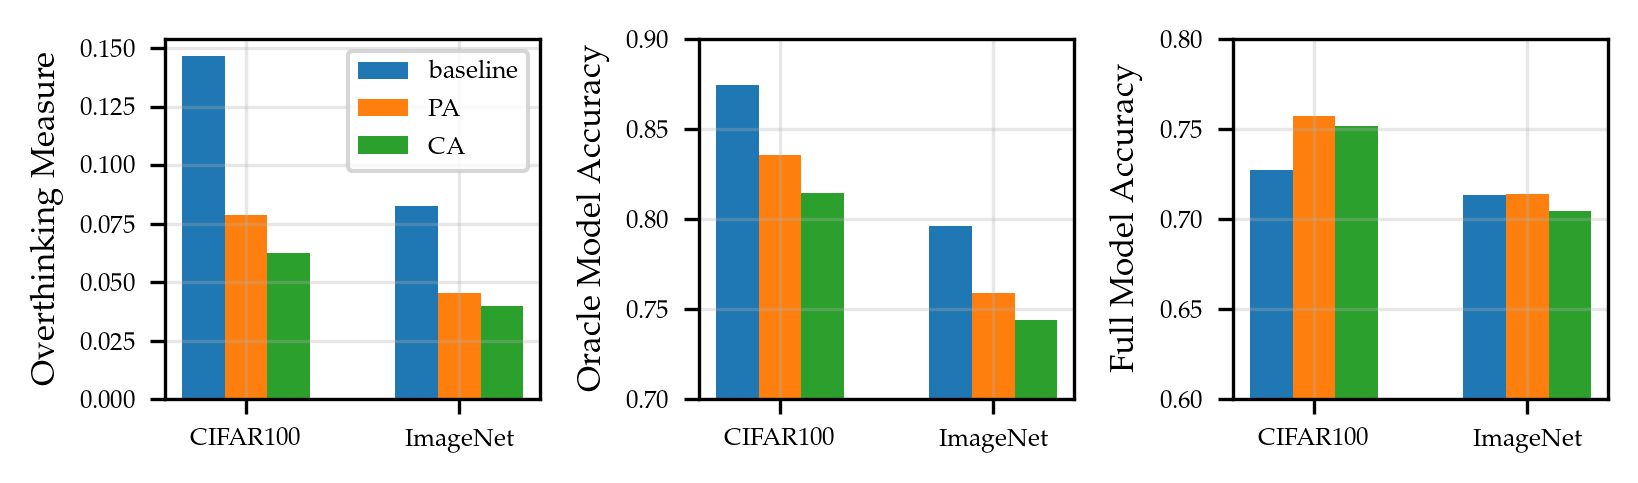

In [12]:
datasets = ['CIFAR100', 'ImageNet']
models = ['baseline', 'PA', 'CA']
cifar100_values = [v[2] for v in CIFAR_100_DICT.values()]
imagenet_values = [v[2] for v in IMAGE_NET_DICT.values()]

num_models = len(models)
width = 0.2

fig, ax = plt.subplots(1, 3, figsize=(text_width, 0.3*text_width))

# Plot bars for each model within each dataset group
for i, model in enumerate(models):
    model_values = [CIFAR_100_DICT[model][2], IMAGE_NET_DICT[model][2]]
    rects = ax[0].bar(np.arange(len(datasets)) + i * width, model_values, width, label=model)

# Customize plot
ax[0].set_ylabel('Overthinking Measure')
ax[0].set_xticks(np.arange(len(datasets)) + width * (num_models - 1) / 2)
ax[0].set_xticklabels(datasets)
ax[0].legend()


# Plot bars for each model within each dataset group
for i, model in enumerate(models):
    model_values = [CIFAR_100_DICT[model][0], IMAGE_NET_DICT[model][0]]
    rects = ax[1].bar(np.arange(len(datasets)) + i * width, model_values, width, label=model)

# Customize plot
ax[1].set_ylabel('Oracle Model Accuracy')
ax[1].set_xticks(np.arange(len(datasets)) + width * (num_models - 1) / 2)
ax[1].set_xticklabels(datasets)
ax[1].set_ylim([0.7, 0.9])
# ax[1].legend()


# Plot bars for each model within each dataset group
for i, model in enumerate(models):
    model_values = [CIFAR_100_DICT[model][1], IMAGE_NET_DICT[model][1]]
    rects = ax[2].bar(np.arange(len(datasets)) + i * width, model_values, width, label=model)

# Customize plot
ax[2].set_ylabel('Full Model Accuracy')
ax[2].set_xticks(np.arange(len(datasets)) + width * (num_models - 1) / 2)
ax[2].set_xticklabels(datasets)
ax[2].set_ylim([0.6, 0.8])
# ax[1].legend()

# Display plot
plt.savefig(f'figures/figure_overthinking.pdf', dpi=1200, bbox_inches='tight')
plt.show()

# Figure Learn vs Forget appendix

In [15]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [16]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]

probs_ca = anytime_caching(probs, N=N, L=L)
preds_ca = {i: torch.argmax(probs_ca, dim=2)[i, :] for i in range(L)}
acc_ca = [(targets == preds_ca[i]).sum() / len(targets) for i in range(L)]

T = 1.
probs_pa = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_pa = {i: torch.argmax(probs_pa, dim=2)[i, :] for i in range(L)}
acc_pa = [(targets == preds_pa[i]).sum() / len(targets) for i in range(L)]

In [17]:
learn_dict = {}
for name, _preds, _acc in zip(['base', 'PA', 'CA'], [preds, preds_pa, preds_ca], [acc, acc_pa, acc_ca]):
    correct_ids = []
    for n in range(N):
        preds_all = [_preds[l][n] for l in range(L)]
        if targets[n] in preds_all:
            correct_ids.append((n, preds_all.index(targets[n])))
    
    print(len(correct_ids) / N, float(_acc[-1]), float(len(correct_ids)  / N - _acc[-1]))

    learn_dict[name] = correct_ids


forget_dict = {}
for name, _preds, _acc in zip(['base', 'PA', 'CA'], [preds, preds_pa, preds_ca], [acc, acc_pa, acc_ca]):
    forget_ids = []
    for n in range(N):
        for l in range(1, L):

            if _preds[l][n] != targets[n] and _preds[l - 1][n] == targets[n]:
                forget_ids.append((n, l))
                break

    forget_dict[name] = forget_ids

0.8732 0.728600025177002 0.14459997415542603
0.8332 0.7559000253677368 0.07729995250701904
0.8127 0.7515000104904175 0.061199963092803955


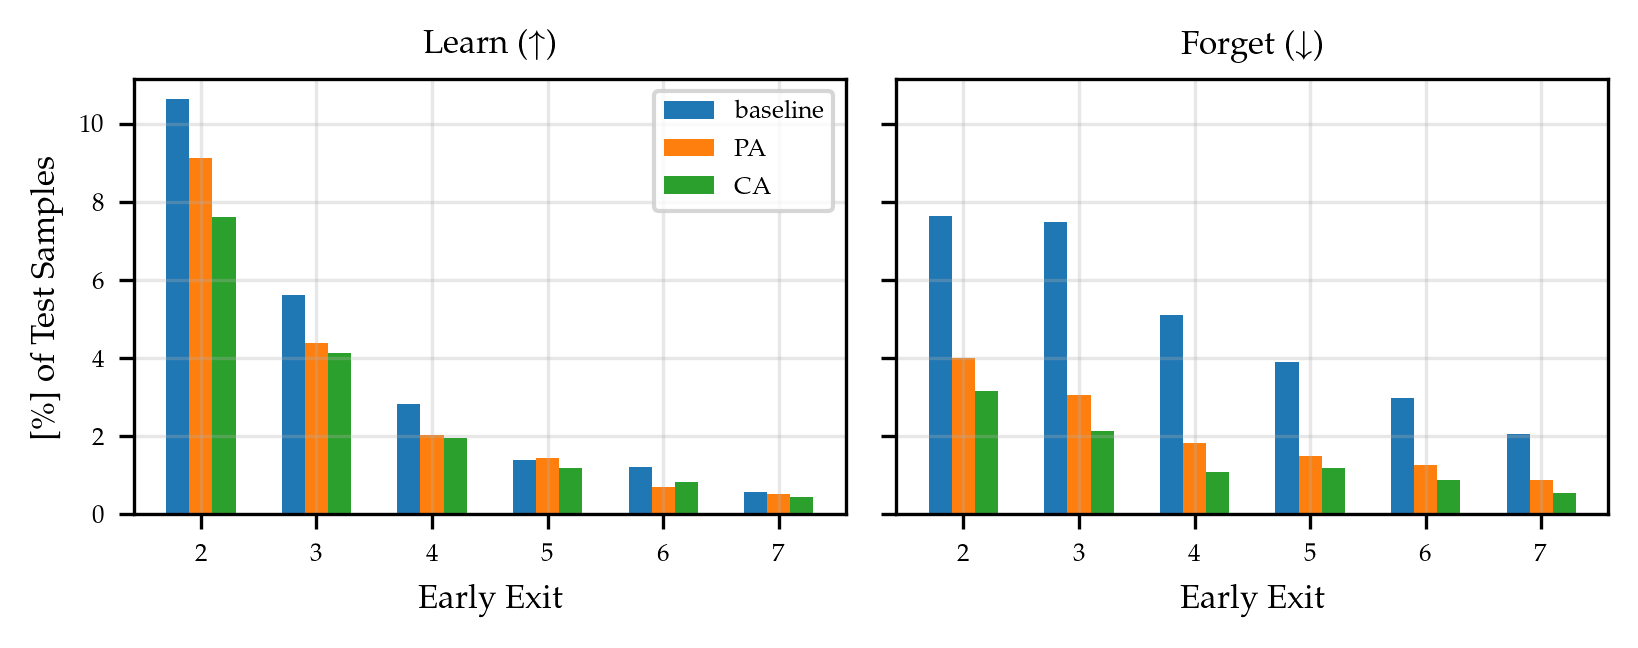

In [28]:
# sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(text_width, 0.4*text_width), sharey=True)

ax[0].set_title('Learn (↑)')
ax[1].set_title('Forget (↓)')

ax[0].set_ylabel('[\%] of Test Samples')
ax[0].set_xlabel('Early Exit')
ax[1].set_xlabel('Early Exit')

ax[0].bar(list(Counter([x[1] + 1 - 0.2 for x in learn_dict['base']]).keys())[1:], [(x / N) * 100 for x in list(Counter([x[1] + 1 for x in learn_dict['base']]).values())][1:], width=0.2, label='baseline')
ax[0].bar(list(Counter([x[1] + 1 for x in learn_dict['PA']]).keys())[1:], [(x / N) * 100 for x in list(Counter([x[1] + 1 for x in learn_dict['PA']]).values())][1:], width=0.2, label='PA')
ax[0].bar(list(Counter([x[1] + 1 + 0.2 for x in learn_dict['CA']]).keys())[1:], [(x / N) * 100 for x in list(Counter([x[1] + 1 for x in learn_dict['CA']]).values())][1:], width=0.2, label='CA')
ax[0].set_xticks(list(range(2, L + 1)))
ax[0].legend()

ax[1].bar(list(Counter([x[1] + 1 - 0.2 for x in forget_dict['base']]).keys()), [(x / N) * 100 for x in list(Counter([x[1] + 1 for x in forget_dict['base']]).values())], width=0.2, label='baseline')
ax[1].bar(list(Counter([x[1] + 1 for x in forget_dict['PA']]).keys()), [(x / N) * 100 for x in list(Counter([x[1] + 1 for x in forget_dict['PA']]).values())], width=0.2, label='PA')
ax[1].bar(list(Counter([x[1] + 1 + 0.2 for x in forget_dict['CA']]).keys()), [(x / N) * 100 for x in list(Counter([x[1] + 1 for x in forget_dict['CA']]).values())], width=0.2, label='CA')
ax[1].set_xticks(list(range(2, L + 1)))

plt.savefig(f'figures/figure_learn_vs_forget.pdf', dpi=1200, bbox_inches='tight')
plt.show()

# Figure Softplus Finetuning

In [3]:
###### CIFAR-100 ######
logits, targets, _ = get_logits_targets('cifar100', 'models', 'softmax', 298, cuda=True)

##### CIFAR-100 ##### MOST PROMISING
# logits_a, targets_a, ARGS = get_logits_targets('cifar100', 'models_prod_softplus_finetuning_stop_grad', 'softmax', 299, cuda=True)
logits_a, targets_a, _ = get_logits_targets('cifar100', 'models_prod_softplus_finetuning_100', 'softmax', 299, cuda=True)



###### CIFAR-10 ######
logits_C10, targets_C10, _ = get_logits_targets('cifar10', 'models_rerun', 'softmax', 299, cuda=True)



##### CIFAR-10 ##### MOST PROMISING
logits_a_C10, targets_a_C10, _ = get_logits_targets('cifar10', 'models_rerun_finetuning_199', 'softmax', 299, cuda=True)


##### ImageNet #####
with open(f'output/ImageNet.p', 'rb') as f:
    data = pickle.load(f)
logits_IM, targets_IM, _ = data
logits_a_IM, targets_a_IM, _ = get_logits_targets_image_net(model_path='models_image_net/models_finetuning_59_stop_grad/save_models', model_name='checkpoint_089.pth.tar')

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

782it [01:26,  9.06it/s]


In [18]:
res_dict = {}
for _logits, _logits_a, _targets, _targets_a, label in zip([logits_C10, logits, logits_IM], [logits_a_C10, logits_a, logits_a_IM], 
                                                           [targets_C10, targets, targets_IM], [targets_a_C10, targets_a, targets_a_IM], ['CIFAR-10', 'CIFAR-100', 'ImageNet']):
    L, N = len(_logits), len(_targets)

    probs = torch.softmax(_logits, dim=2)
    preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
    acc = [(_targets == preds[i]).sum() / len(_targets) for i in range(L)]


    probs_pa_softplus = torch.tensor(f_probs_pa_softplus(_logits_a, weights=None))
    preds_pa_softplus = {i: torch.argmax(probs_pa_softplus, dim=2)[i, :] for i in range(L)}
    acc_pa_softplus = [(_targets_a == preds_pa_softplus[i]).sum() / len(_targets_a) for i in range(L)]


    probs_pa = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(_logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) ))
    preds_pa = {i: torch.argmax(probs_pa, dim=2)[i, :] for i in range(L)}
    acc_pa = [(_targets == preds_pa[i]).sum() / len(_targets) for i in range(L)]

    assert (_targets == _targets_a).all()

    res_dict[label] = [(probs, preds, acc, L, N, _targets, 'baseline'), 
                        (probs_pa, preds_pa, acc_pa, L, N, _targets, 'PA'), 
                        (probs_pa_softplus, preds_pa_softplus, acc_pa_softplus, L, N, _targets, 'PA Softplus')]

In [10]:
# (targets == targets_a).all()

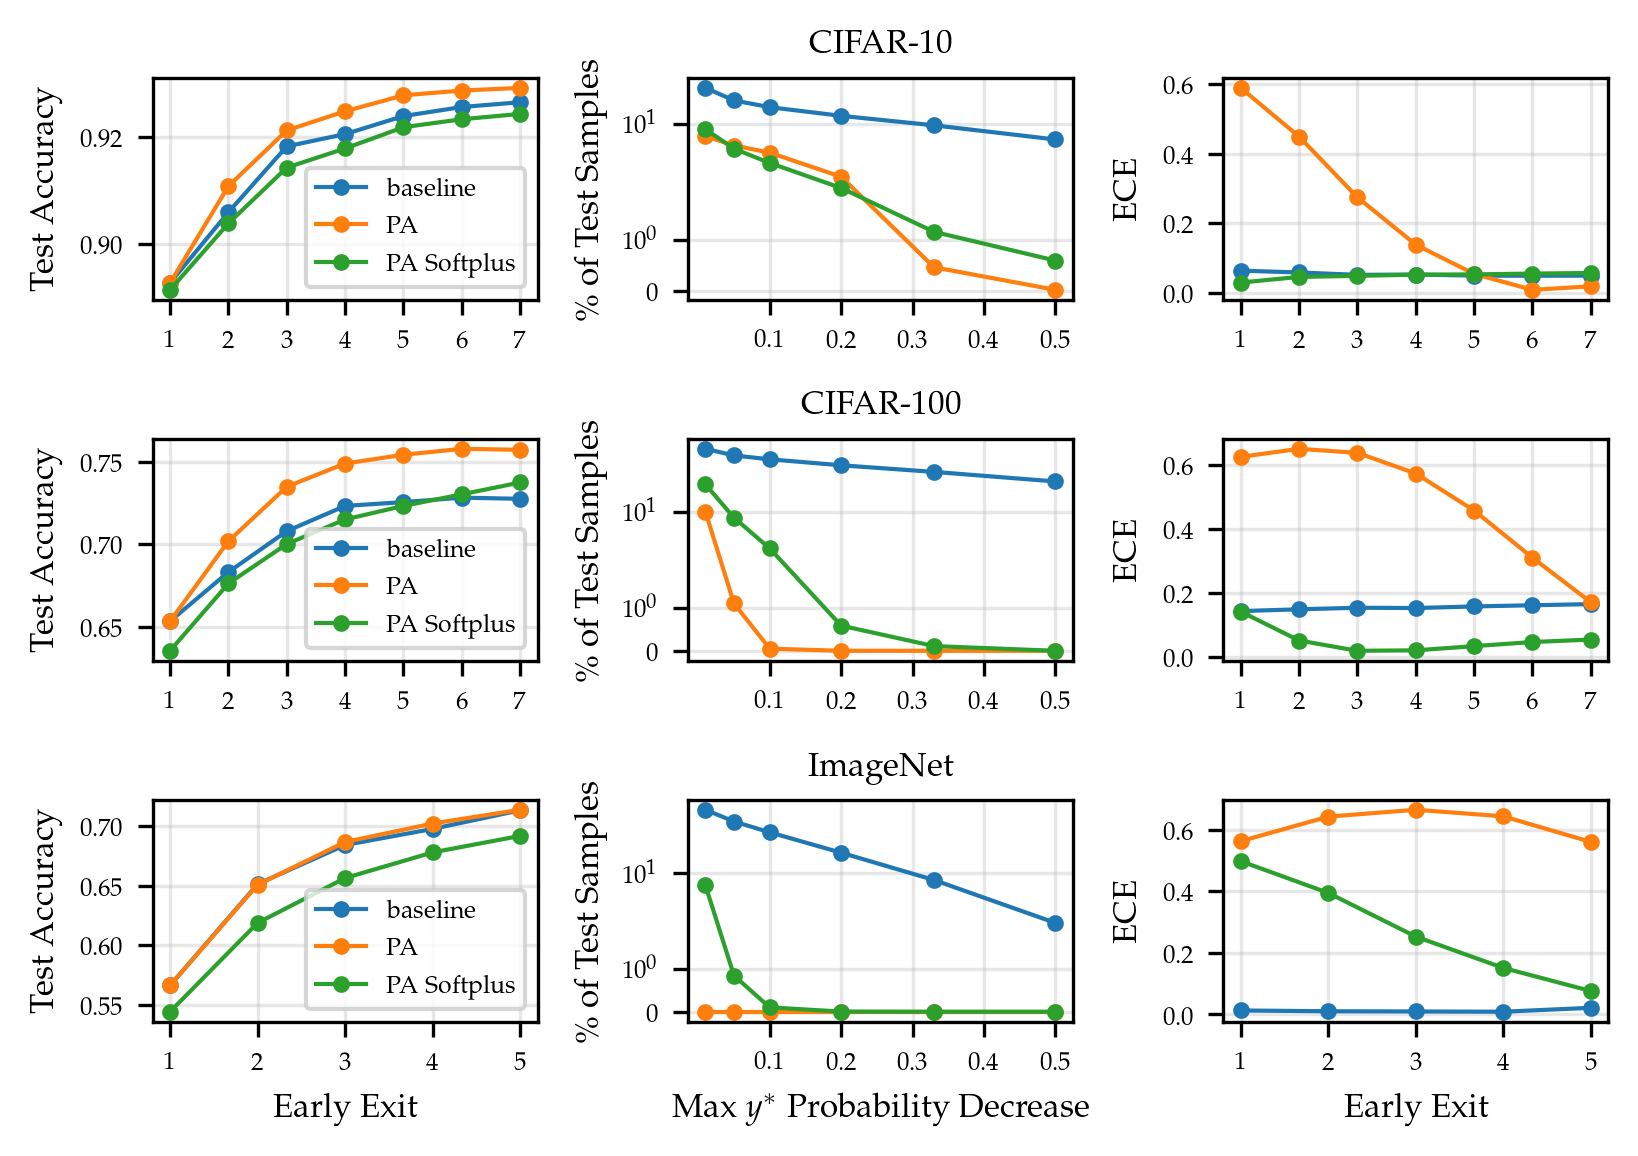

In [26]:

fig, ax = plt.subplots(3, 3, figsize=(text_width, text_width * 4.25/6))
THRESHOLDS = [-0.01, -0.05, -0.1, -0.2, -0.33, -0.5]


i = 0
for dataset, res in res_dict.items():

    for _probs, _preds, _acc, _L, _N, _targets, label in res:

        early_exits = [j + 1 for j in range(_L)]
                                
        
        # _probs = torch.tensor(prob_func(logits, weights=weights))
        # _preds = {i: torch.argmax(_probs, dim=2)[i, :] for i in range(L)}
        # _acc = [(targets == _preds[i]).sum() / len(targets) for i in range(L)]

        ax[i, 0].plot(early_exits, _acc, label=label, marker='o',)

        # modal_probs = modal_probs_decreasing(_preds, _probs, layer=L, N=N, diffs_type='all', thresholds=THRESHOLDS)
        # ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)

        modal_probs = modal_probs_decreasing(_targets, _probs, layer=None, N=_N, diffs_type='all', thresholds=THRESHOLDS)
        ax[i, 1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)

        ece = []
        for l in range(_L):
            ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), _targets.numpy()))
        ax[i, 2].plot(early_exits, ece, marker='o', label=label)



    ax[i, 0].legend()
    ax[i, 0].set_ylabel('Test Accuracy')
    

    # ax[1].set_xlabel('max decrease in modal probability')
    # ax[1].set_ylabel('% of test examples')

    
    ax[i, 1].set_ylabel('\% of Test Samples')
    ax[i, 1].set_yscale('symlog')

    ax[i, 2].set_ylabel('ECE')

    ax[i, 0].set_xticks(early_exits)
    ax[i, 1].set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
    ax[i, 2].set_xticks(early_exits)

    ax[i, 1].set_title(dataset)
    

    if i == 2:
        ax[i, 0].set_xlabel('Early Exit')
        ax[i, 1].set_xlabel('Max $y^*$ Probability Decrease')
        ax[i, 2].set_xlabel('Early Exit')

    i += 1


plt.tight_layout()
plt.savefig(f'figures/figure_softplus_finetuning.pdf', bbox_inches='tight')
plt.show()